# Autoencoder Embeddings for Adaptive Model Selection and Drift Detection

As part of my bachelor thesis, this notebook explores how autoencoder-derived embeddings can be used to dynamically select the most suitable forecasting model, in contrast to conventional approaches based on raw time-domain similarity. Concept drift detection is handled in a separate notebook.

---

### RQ1: Latent vs. Raw Space for Model Selection
- [Test 1.1: Forecasting MSE Comparison](#test-11-forecasting-mse-comparison)
- [Test 1.2: Win Rate Analysis](#test-12-win-rate-analysis)
- [Test 1.3: Neighbor-Set Overlap](#test-13-neighbor-set-overlap)
### RQ2: Cluster-Based Latent Selection
- [Test 2.1: Forecasting MSE Comparison](#test-21-forecasting-mse-comparison)
- [Test 2.2: Visualization](#test-22-visualization)

### Imports

In [1]:
import os
import time
import math
import random
import pickle
import shutil
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from forecasters import *
from autoencoder import *
from utils import *
from data import *

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

### Seeding

In [2]:
# Set a global seed for reproducibility
seed = 42

# Seed Python, NumPy, and PyTorch RNGs
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Create and seed a PyTorch Generator (for Dataloaders)
g= torch.Generator()
g.manual_seed(seed)

# Seed CUDA (if available)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Ensure deterministic behavior in cuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Configuration Setup

Defines experiment parameters, including autoencoder bottleneck size, datasets (with length and window size), and distance metrics. The compute device (CPU/GPU) is selected automatically.

The experiment is conducted using four distinct datasets:
- **Energy Dataset:** Electricity consumption of a single client aggregated to 3-hour intervals (2012–2014); captures regular usage cycles. 
- **River Flow Dataset:** Daily mean flow of the Saugeen River (1915–1979, 23,741 days); strong seasonality and long-term dependencies.
- **Temperatures Dataset:** Daily minimum temperatures in Melbourne (1981–1990, 3650 days); smooth seasonal cycles with mild variability.
- **Births Dataset:** Daily US birth counts from 1969 to 1988 (7305 days); low variability and weak seasonality.

In [3]:
# Directory paths for saving and loading components
AE_DIR = "trained_autoencoders"
FORECASTERS_DIR= "trained_forecasters"
RESULTS_DIR = "results"

# Size of the autoencoder bottleneck
latent_dim = 2

# Dataset configurations: (Name, Class, Sequence Length, Window Size)
ts_configs = [
    ("Energy",       PowerDemand,  None, 10),
    ("RiverFlow",    Saugeen,      None, 10),
    ("Temperatures", Temperatures, None, 10),
    ("Births",       Births,       None, 10)
]

# Flags to toggle use of autoencoder embeddings
autoencoder_embedding_flags = [False, True]

# Distance metrics to evaluate
metrics_list = ["dtw", "euclidean", "cosine", "manhattan"]

# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Autoencoder Training and Evaluation

For each dataset, a convolutional autoencoder is trained on windowed time-series data using MSE loss. The model is trained for 30 epochs and saved for later use.


Training AE on Energy (window_size=10)
  Epoch 1/30 — loss: 0.317051
  Epoch 2/30 — loss: 0.117074
  Epoch 3/30 — loss: 0.096623
  Epoch 4/30 — loss: 0.086106
  Epoch 5/30 — loss: 0.080039
  Epoch 6/30 — loss: 0.075544
  Epoch 7/30 — loss: 0.071566
  Epoch 8/30 — loss: 0.069444
  Epoch 9/30 — loss: 0.067669
  Epoch 10/30 — loss: 0.065070
  Epoch 11/30 — loss: 0.064500
  Epoch 12/30 — loss: 0.063579
  Epoch 13/30 — loss: 0.062727
  Epoch 14/30 — loss: 0.060030
  Epoch 15/30 — loss: 0.060311
  Epoch 16/30 — loss: 0.059868
  Epoch 17/30 — loss: 0.058307
  Epoch 18/30 — loss: 0.057552
  Epoch 19/30 — loss: 0.057494
  Epoch 20/30 — loss: 0.055212
  Epoch 21/30 — loss: 0.054045
  Epoch 22/30 — loss: 0.052425
  Epoch 23/30 — loss: 0.050840
  Epoch 24/30 — loss: 0.049978
  Epoch 25/30 — loss: 0.049733
  Epoch 26/30 — loss: 0.047951
  Epoch 27/30 — loss: 0.048079
  Epoch 28/30 — loss: 0.046612
  Epoch 29/30 — loss: 0.046042
  Epoch 30/30 — loss: 0.045428
Saved AE: trained_autoencoders\ae_Energ

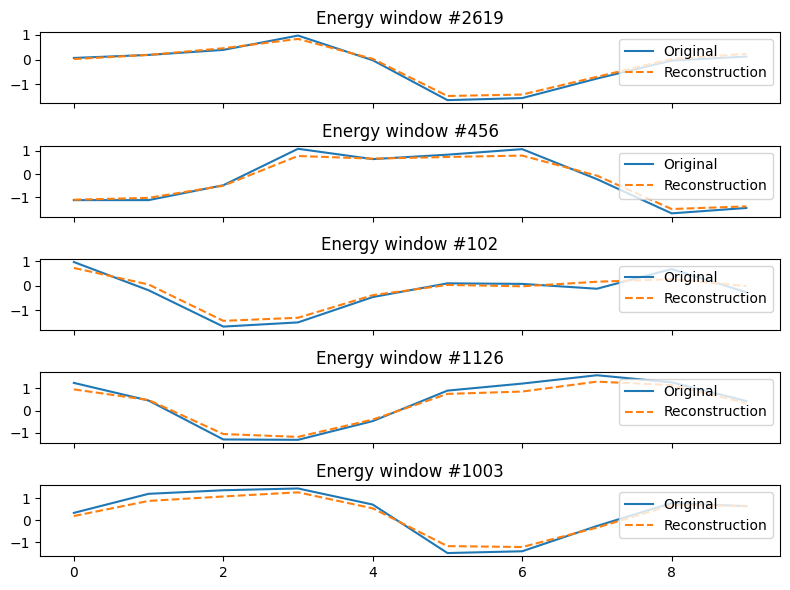


Training AE on RiverFlow (window_size=10)
  Epoch 1/30 — loss: 0.238155
  Epoch 2/30 — loss: 0.102744
  Epoch 3/30 — loss: 0.088488
  Epoch 4/30 — loss: 0.084368
  Epoch 5/30 — loss: 0.080801
  Epoch 6/30 — loss: 0.075768
  Epoch 7/30 — loss: 0.079604
  Epoch 8/30 — loss: 0.073374
  Epoch 9/30 — loss: 0.069960
  Epoch 10/30 — loss: 0.067946
  Epoch 11/30 — loss: 0.062512
  Epoch 12/30 — loss: 0.069561
  Epoch 13/30 — loss: 0.060022
  Epoch 14/30 — loss: 0.057834
  Epoch 15/30 — loss: 0.066191
  Epoch 16/30 — loss: 0.052762
  Epoch 17/30 — loss: 0.054031
  Epoch 18/30 — loss: 0.056004
  Epoch 19/30 — loss: 0.056895
  Epoch 20/30 — loss: 0.054072
  Epoch 21/30 — loss: 0.050450
  Epoch 22/30 — loss: 0.055747
  Epoch 23/30 — loss: 0.055698
  Epoch 24/30 — loss: 0.054540
  Epoch 25/30 — loss: 0.048252
  Epoch 26/30 — loss: 0.051355
  Epoch 27/30 — loss: 0.048395
  Epoch 28/30 — loss: 0.051821
  Epoch 29/30 — loss: 0.050011
  Epoch 30/30 — loss: 0.051123
Saved AE: trained_autoencoders\ae_Ri

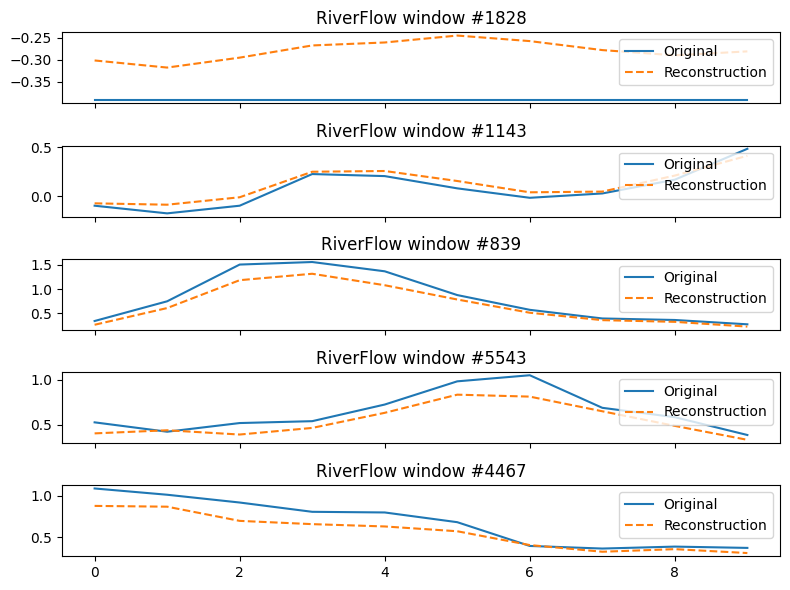


Training AE on Temperatures (window_size=10)
  Epoch 1/30 — loss: 0.608663
  Epoch 2/30 — loss: 0.329793
  Epoch 3/30 — loss: 0.274303
  Epoch 4/30 — loss: 0.234640
  Epoch 5/30 — loss: 0.209163
  Epoch 6/30 — loss: 0.200630
  Epoch 7/30 — loss: 0.181806
  Epoch 8/30 — loss: 0.166926
  Epoch 9/30 — loss: 0.168314
  Epoch 10/30 — loss: 0.152162
  Epoch 11/30 — loss: 0.149732
  Epoch 12/30 — loss: 0.137245
  Epoch 13/30 — loss: 0.138601
  Epoch 14/30 — loss: 0.127638
  Epoch 15/30 — loss: 0.123823
  Epoch 16/30 — loss: 0.131054
  Epoch 17/30 — loss: 0.119413
  Epoch 18/30 — loss: 0.117879
  Epoch 19/30 — loss: 0.122083
  Epoch 20/30 — loss: 0.109828
  Epoch 21/30 — loss: 0.105165
  Epoch 22/30 — loss: 0.106567
  Epoch 23/30 — loss: 0.098311
  Epoch 24/30 — loss: 0.103879
  Epoch 25/30 — loss: 0.096166
  Epoch 26/30 — loss: 0.097212
  Epoch 27/30 — loss: 0.103852
  Epoch 28/30 — loss: 0.098756
  Epoch 29/30 — loss: 0.095429
  Epoch 30/30 — loss: 0.091324
Saved AE: trained_autoencoders\ae

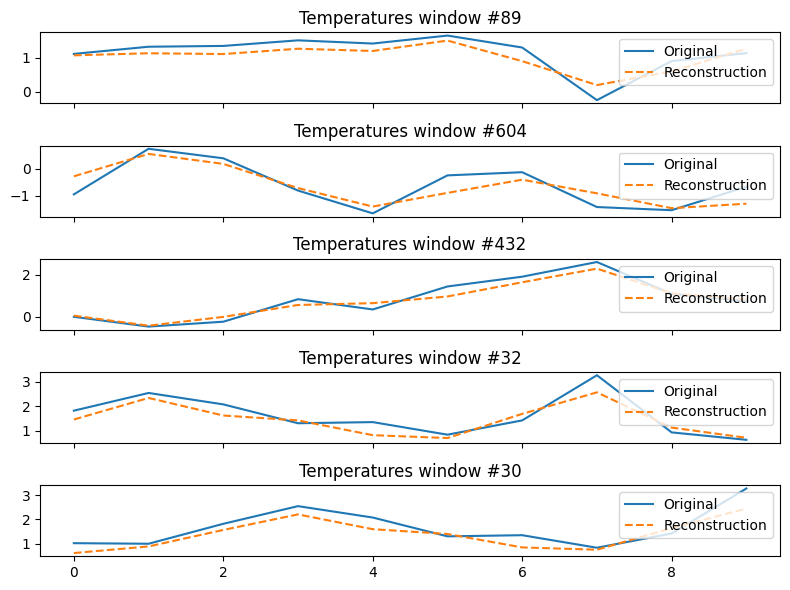


Training AE on Births (window_size=10)
  Epoch 1/30 — loss: 0.467740
  Epoch 2/30 — loss: 0.223870
  Epoch 3/30 — loss: 0.168922
  Epoch 4/30 — loss: 0.146277
  Epoch 5/30 — loss: 0.129893
  Epoch 6/30 — loss: 0.118102
  Epoch 7/30 — loss: 0.108919
  Epoch 8/30 — loss: 0.101542
  Epoch 9/30 — loss: 0.095733
  Epoch 10/30 — loss: 0.091487
  Epoch 11/30 — loss: 0.087671
  Epoch 12/30 — loss: 0.082445
  Epoch 13/30 — loss: 0.080942
  Epoch 14/30 — loss: 0.076589
  Epoch 15/30 — loss: 0.076455
  Epoch 16/30 — loss: 0.073071
  Epoch 17/30 — loss: 0.077745
  Epoch 18/30 — loss: 0.072583
  Epoch 19/30 — loss: 0.069790
  Epoch 20/30 — loss: 0.068987
  Epoch 21/30 — loss: 0.069546
  Epoch 22/30 — loss: 0.066952
  Epoch 23/30 — loss: 0.069591
  Epoch 24/30 — loss: 0.070140
  Epoch 25/30 — loss: 0.063802
  Epoch 26/30 — loss: 0.062223
  Epoch 27/30 — loss: 0.062913
  Epoch 28/30 — loss: 0.061256
  Epoch 29/30 — loss: 0.062327
  Epoch 30/30 — loss: 0.061728
Saved AE: trained_autoencoders\ae_Birth

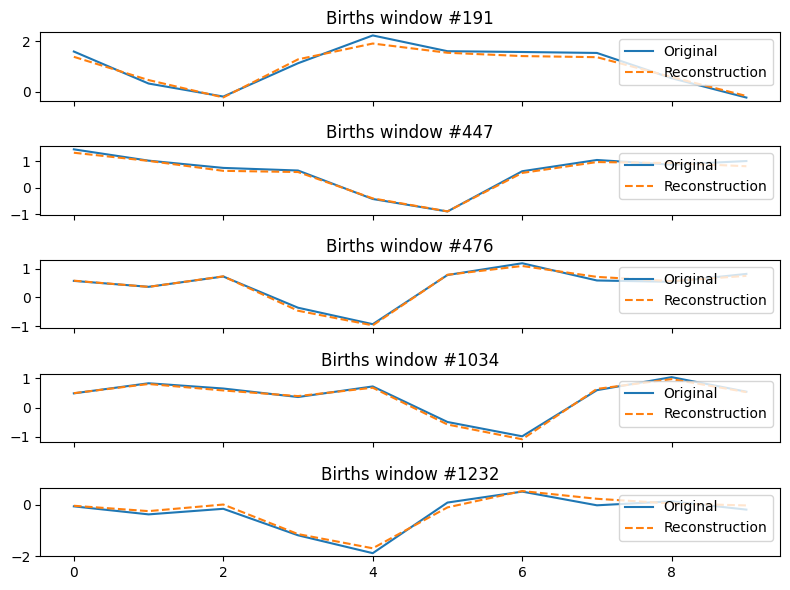

In [4]:
# Autoencoder Training Settings
epochs    = 30
lr        = 1e-3
dropout_p = 0.3

# Ensure a clean autoencoders/ directory
if os.path.exists(AE_DIR):
    shutil.rmtree(AE_DIR)
os.makedirs(AE_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\nTraining AE on {ds_name} (window_size={window_size})")
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)
    
    
    # model + optimizer + loss
    ae        = ConvAutoencoder1D(window_size, latent_dim, dropout_p).to(device)
    optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    # wrap as DataLoader of shape (batch, 1, window_size)
    ds_loader = DataLoader(
        TensorDataset(torch.tensor(X_train, dtype=torch.float).unsqueeze(1)),
        batch_size=128, 
        shuffle=True, 
        generator= g
    )
    
    # training loop
    for epoch in range(1, epochs + 1):
        losses = []
        ae.train()
        for (batch_x,) in ds_loader:
            batch_x = batch_x.to(device)
            recon   = ae(batch_x)
            loss    = criterion(recon, batch_x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        print(f"  Epoch {epoch}/{epochs} — loss: {np.mean(losses):.6f}")
    
    # save per‐dataset autoencoder
    ckpt_path = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    torch.save(ae.state_dict(), ckpt_path)
    print(f"Saved AE: {ckpt_path}")

    # 6. Visualize reconstructions in eval mode
    ae.eval()
    sample_idxs = random.sample(range(len(X_val)), 5)
    fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True)
    for ax, idx in zip(axes, sample_idxs):
        orig = X_train[idx]
        with torch.no_grad():
            inp = torch.tensor(orig, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)
            recon = ae(inp).cpu().squeeze().numpy()
        ax.plot(orig, label="Original")
        ax.plot(recon, linestyle="--", label="Reconstruction")
        ax.set_title(f"{ds_name} window #{idx}")
        ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

### Forecaster Training

For each dataset, a collection of classical and neural network-based forecasters are trained on the training split. Each trained model is saved as a serialized `.pkl` file for future evaluation and selection.

In [5]:
# Ensure a clean forecasters/ directory
if os.path.exists(FORECASTERS_DIR):
    shutil.rmtree(FORECASTERS_DIR)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Dataset: {ds_name} (window_size={window_size})")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    forecasters = {
    "ARIMA": ARIMAForecaster(),
    "ExpSmoothing": ExpSmoothingForecaster(),
    "LinearRegression": LinearRegressionForecaster(),
    "RandomForest": RandomForestForecaster(random_state=seed),
    "SVR": SVRForecaster(),
    "GradientBoosting": GradientBoostingForecaster(random_state=seed),
    "DT": DecisionTreeForecaster(random_state=seed),
    "MLP1": MLPForecaster(hidden_layer_sizes=(64,), random_state=seed),
    "MLP2": MLPForecaster(hidden_layer_sizes=(64, 32), random_state=seed),
    "MLP3": MLPForecaster(hidden_layer_sizes=(128, 64, 32), random_state=seed),
    "LSTM1": LSTMForecaster(),
    "LSTM2": LSTMForecaster(num_layers=2),
    "LSTM3": LSTMForecaster(num_layers=3),
    "BiLSTM1": BiLSTMForecaster(),
    "BiLSTM2": BiLSTMForecaster(num_layers=2),
    "BiLSTM3": BiLSTMForecaster(num_layers=3),
    "CNNLSTM1": CNNLSTMForecaster(),
    "CNNLSTM2": CNNLSTMForecaster(lstm_num_layers=2),
    "CNNLSTM3": CNNLSTMForecaster(lstm_num_layers=3),
    }

    for name, model in forecasters.items():
        print(f"    → Training {name}…", end=" ")
        model.fit(X_train, y_train, generator=g)

        # save the entire model object as a .pkl
        save_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(model, f)
        print(f"DONE")


→ Dataset: Energy (window_size=10)
    → Training ARIMA… DONE
    → Training ExpSmoothing… DONE
    → Training LinearRegression… DONE
    → Training RandomForest… DONE
    → Training SVR… DONE
    → Training GradientBoosting… DONE
    → Training DT… DONE
    → Training MLP1… DONE
    → Training MLP2… DONE
    → Training MLP3… DONE
    → Training LSTM1… 1/30 0.73445 | 15/30 0.05568 | 30/30 0.05140 | DONE
    → Training LSTM2… 1/30 0.73096 | 15/30 0.05924 | 30/30 0.05202 | DONE
    → Training LSTM3… 1/30 0.66926 | 15/30 0.07052 | 30/30 0.05890 | DONE
    → Training BiLSTM1… 1/30 0.70388 | 15/30 0.05531 | 30/30 0.04999 | DONE
    → Training BiLSTM2… 1/30 0.59901 | 15/30 0.05671 | 30/30 0.04944 | DONE
    → Training BiLSTM3… 1/30 0.54657 | 15/30 0.05634 | 30/30 0.04653 | DONE
    → Training CNNLSTM1… 1/30 0.49803 | 15/30 0.05270 | 30/30 0.04463 | DONE
    → Training CNNLSTM2… 1/30 0.56335 | 15/30 0.06040 | 30/30 0.05068 | DONE
    → Training CNNLSTM3… 1/30 0.61620 | 15/30 0.06629 | 30/30 

### Model Loading

Pretrained autoencoders and forecasters are loaded from disk for each dataset. These models are stored in a dictionary for subsequent evaluation and model selection steps.

In [6]:
os.makedirs(AE_DIR, exist_ok=True)
os.makedirs(FORECASTERS_DIR, exist_ok=True)

loaded = {}
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n→ Loading models for {ds_name} (window_size={window_size})")
    
    # Load Autoencoder
    ae = ConvAutoencoder1D(window_size, latent_dim, dropout_p).eval().to(device)
    ae_ckpt = os.path.join(AE_DIR, f"ae_{ds_name}.pth")
    ae.load_state_dict(torch.load(ae_ckpt, map_location=device))
    print(f"     AE loaded from {AE_DIR}{os.sep}")
    
    # Load Forecasters
    forecasters = {}
    for name in [
        "ARIMA",
        "ExpSmoothing",
        "LinearRegression",
        "RandomForest",
        "SVR",
        "GradientBoosting",
        "DT",
        "MLP1",
        "MLP2",
        "MLP3",
        "LSTM1",
        "LSTM2",
        "LSTM3",
        "BiLSTM1",
        "BiLSTM2",
        "BiLSTM3",
        "CNNLSTM1",
        "CNNLSTM2",
        "CNNLSTM3",
    ]:
        pkl_path = os.path.join(FORECASTERS_DIR, f"{ds_name}_{name}.pkl")
        with open(pkl_path, "rb") as f:
            forecasters[name] = pickle.load(f)
    print(f"     Forecasters loaded from {FORECASTERS_DIR}{os.sep}")
    
    # Store for later
    loaded[ds_name] = {
        "ae": ae,
        "forecasters": forecasters
    }


→ Loading models for Energy (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for RiverFlow (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for Temperatures (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\

→ Loading models for Births (window_size=10)
     AE loaded from trained_autoencoders\
     Forecasters loaded from trained_forecasters\


### Validation Phase: Region of Competence Construction

Each validation window is used to evaluate all forecasters. The model with the lowest prediction error receives the window as part of its Region of Competence (RoC), stored in both raw and latent representations.


In [7]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Validation RoC for {ds_name} (window_size={window_size}) ===")
    
    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load models
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear both RoCs
    for model in forecasters.values():
        model.rocs["raw"].clear()
        model.rocs["latent"].clear()

    # Iterate once over validation windows
    for idx, window in enumerate(X_val):
        # a) Pick winner based on raw input
        errors = {}
        for name, model in forecasters.items():
            y_pred = model.predict(window)
            errors[name] = mean_squared_error([y_val[idx]], [y_pred])
        winner = min(errors, key=errors.get)

        # b) Store both raw and latent versions
        raw_vec = window
        with torch.no_grad():
            latent_vec = ae.encode(window).cpu()

        forecasters[winner].rocs["raw"].append(raw_vec)
        forecasters[winner].rocs["latent"].append(latent_vec)

    # Report results
    print("RoC sizes")
    for name, model in forecasters.items():
        count = len(model.rocs["raw"])
        print(f"  {name:<18} {count:4d} entries")


=== Validation RoC for Energy (window_size=10) ===
RoC sizes
  ARIMA                68 entries
  ExpSmoothing        149 entries
  LinearRegression    199 entries
  RandomForest        172 entries
  SVR                 282 entries
  GradientBoosting    171 entries
  DT                  194 entries
  MLP1                191 entries
  MLP2                205 entries
  MLP3                221 entries
  LSTM1                90 entries
  LSTM2               101 entries
  LSTM3                94 entries
  BiLSTM1             154 entries
  BiLSTM2             123 entries
  BiLSTM3             108 entries
  CNNLSTM1            146 entries
  CNNLSTM2             98 entries
  CNNLSTM3            146 entries

=== Validation RoC for RiverFlow (window_size=10) ===
RoC sizes
  ARIMA               302 entries
  ExpSmoothing        979 entries
  LinearRegression    148 entries
  RandomForest        184 entries
  SVR                 256 entries
  GradientBoosting    153 entries
  DT                  3

### RoC Clustering

K-means clustering is applied to each model’s latent and raw Regions of Competence (RoC). The optimal number of clusters is estimated, and cluster centers are decoded for visualization. These centers will be used for Cluster-Based model selection.

> Clustering method: All windows are flattened and stacked into a 2D array to serve as input to K-Means algorithm. Then for each value $k$ $\in$ [2, $k_{max}$] we fit a K-Means model, recording the associated inertia (within-cluster sum of squares). The "elbow point" in the inertia curve is identified using the KneeLocator algorithm, selecting the number of clusters that yields the best balance between model complexity and fit quality. The final K-Means clustering is performed with the selected number of clusters, and the resulting cluster centers are reshaped to match the original window shape and type.

Bottleneck size: 2

=== Compute K-means centers for Energy (window_size=10) ===


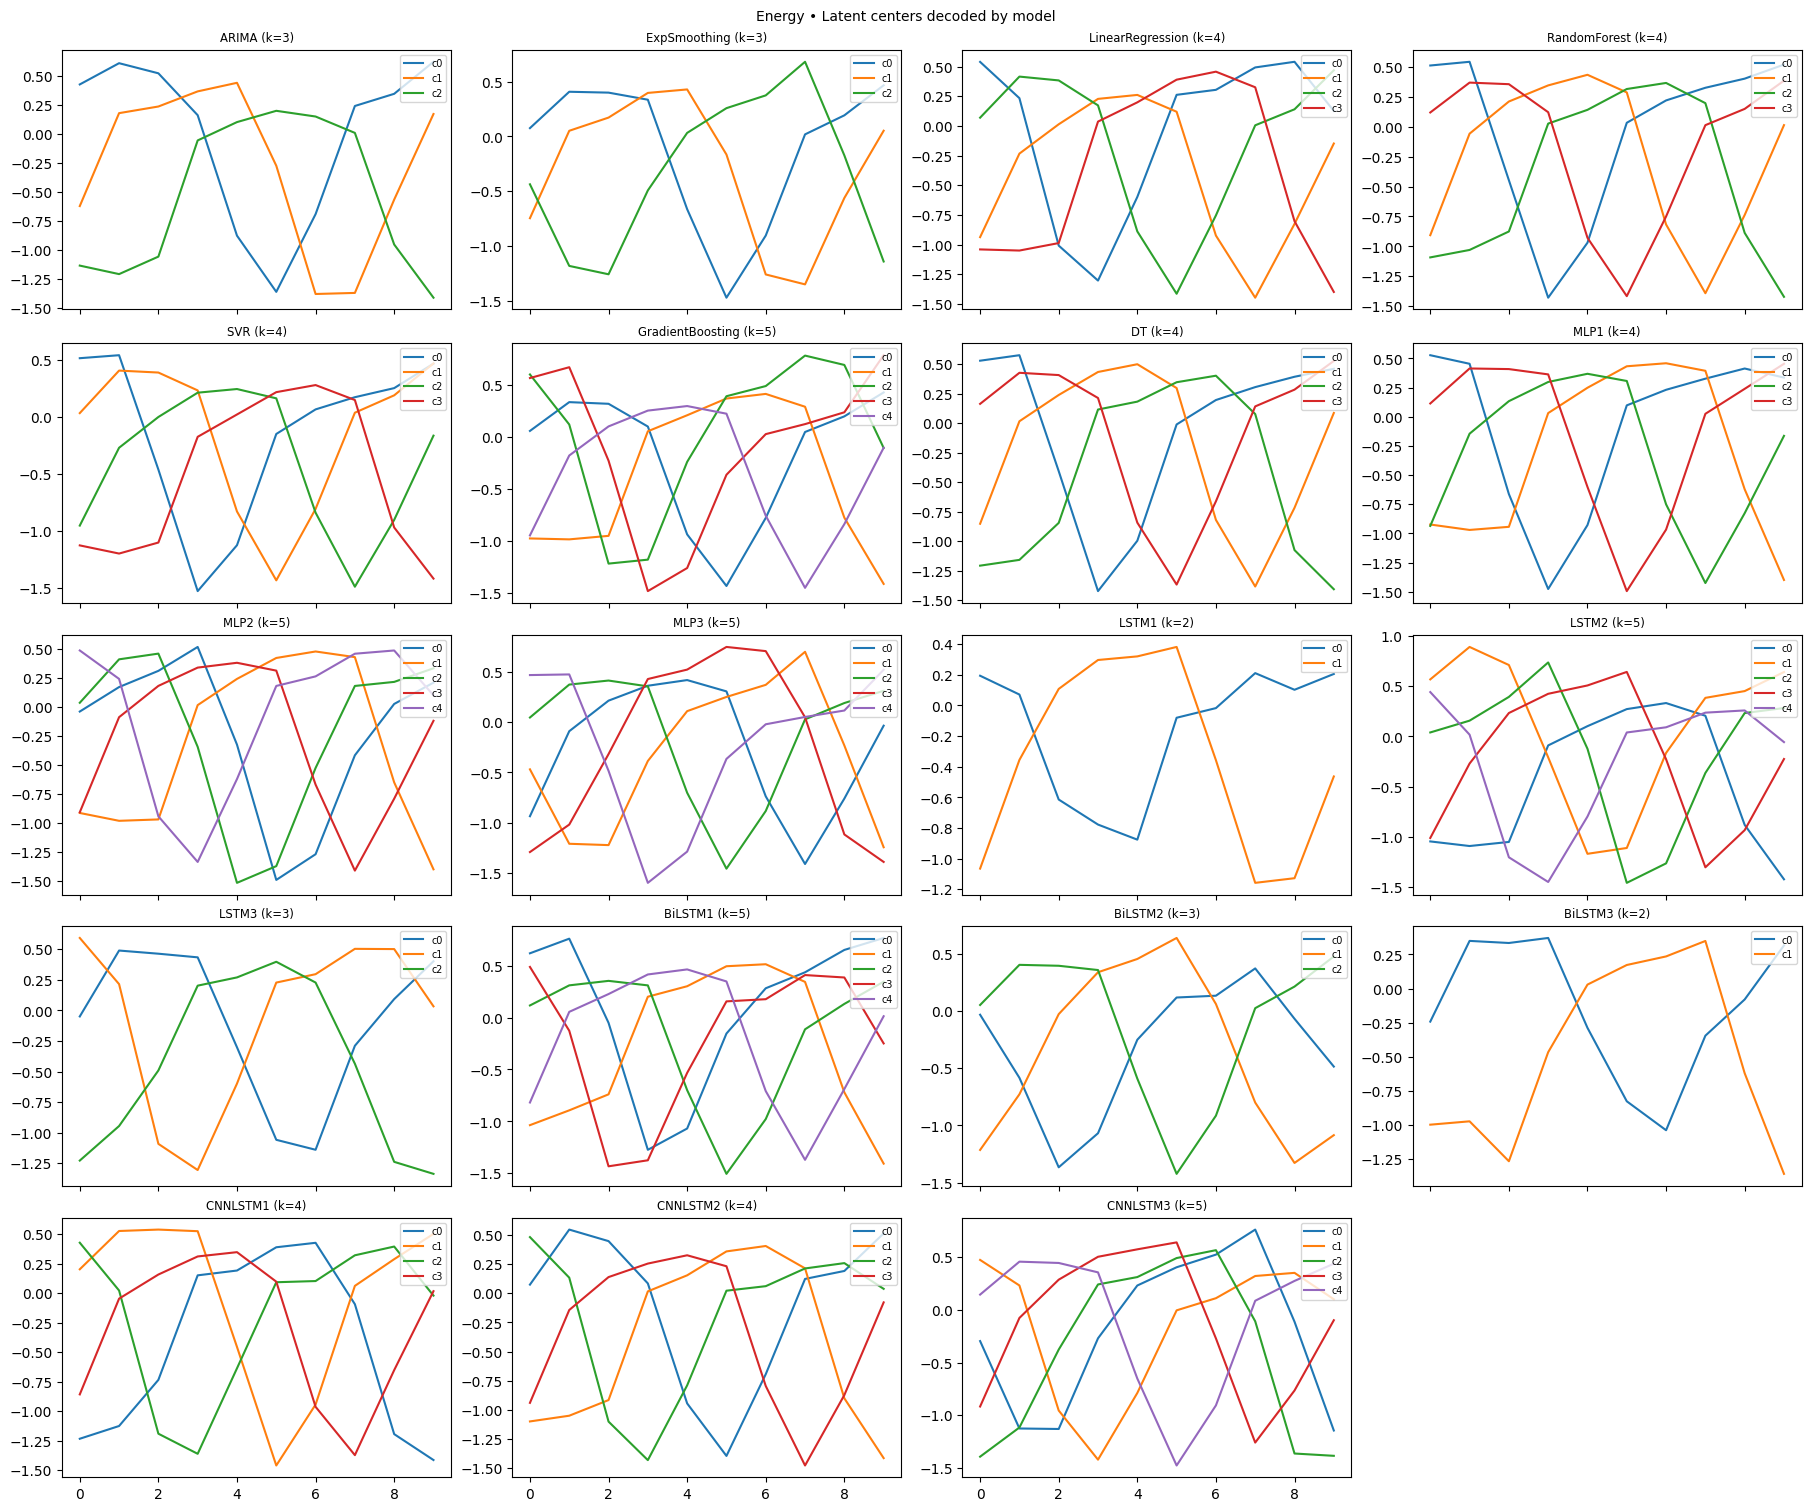


=== Compute K-means centers for RiverFlow (window_size=10) ===


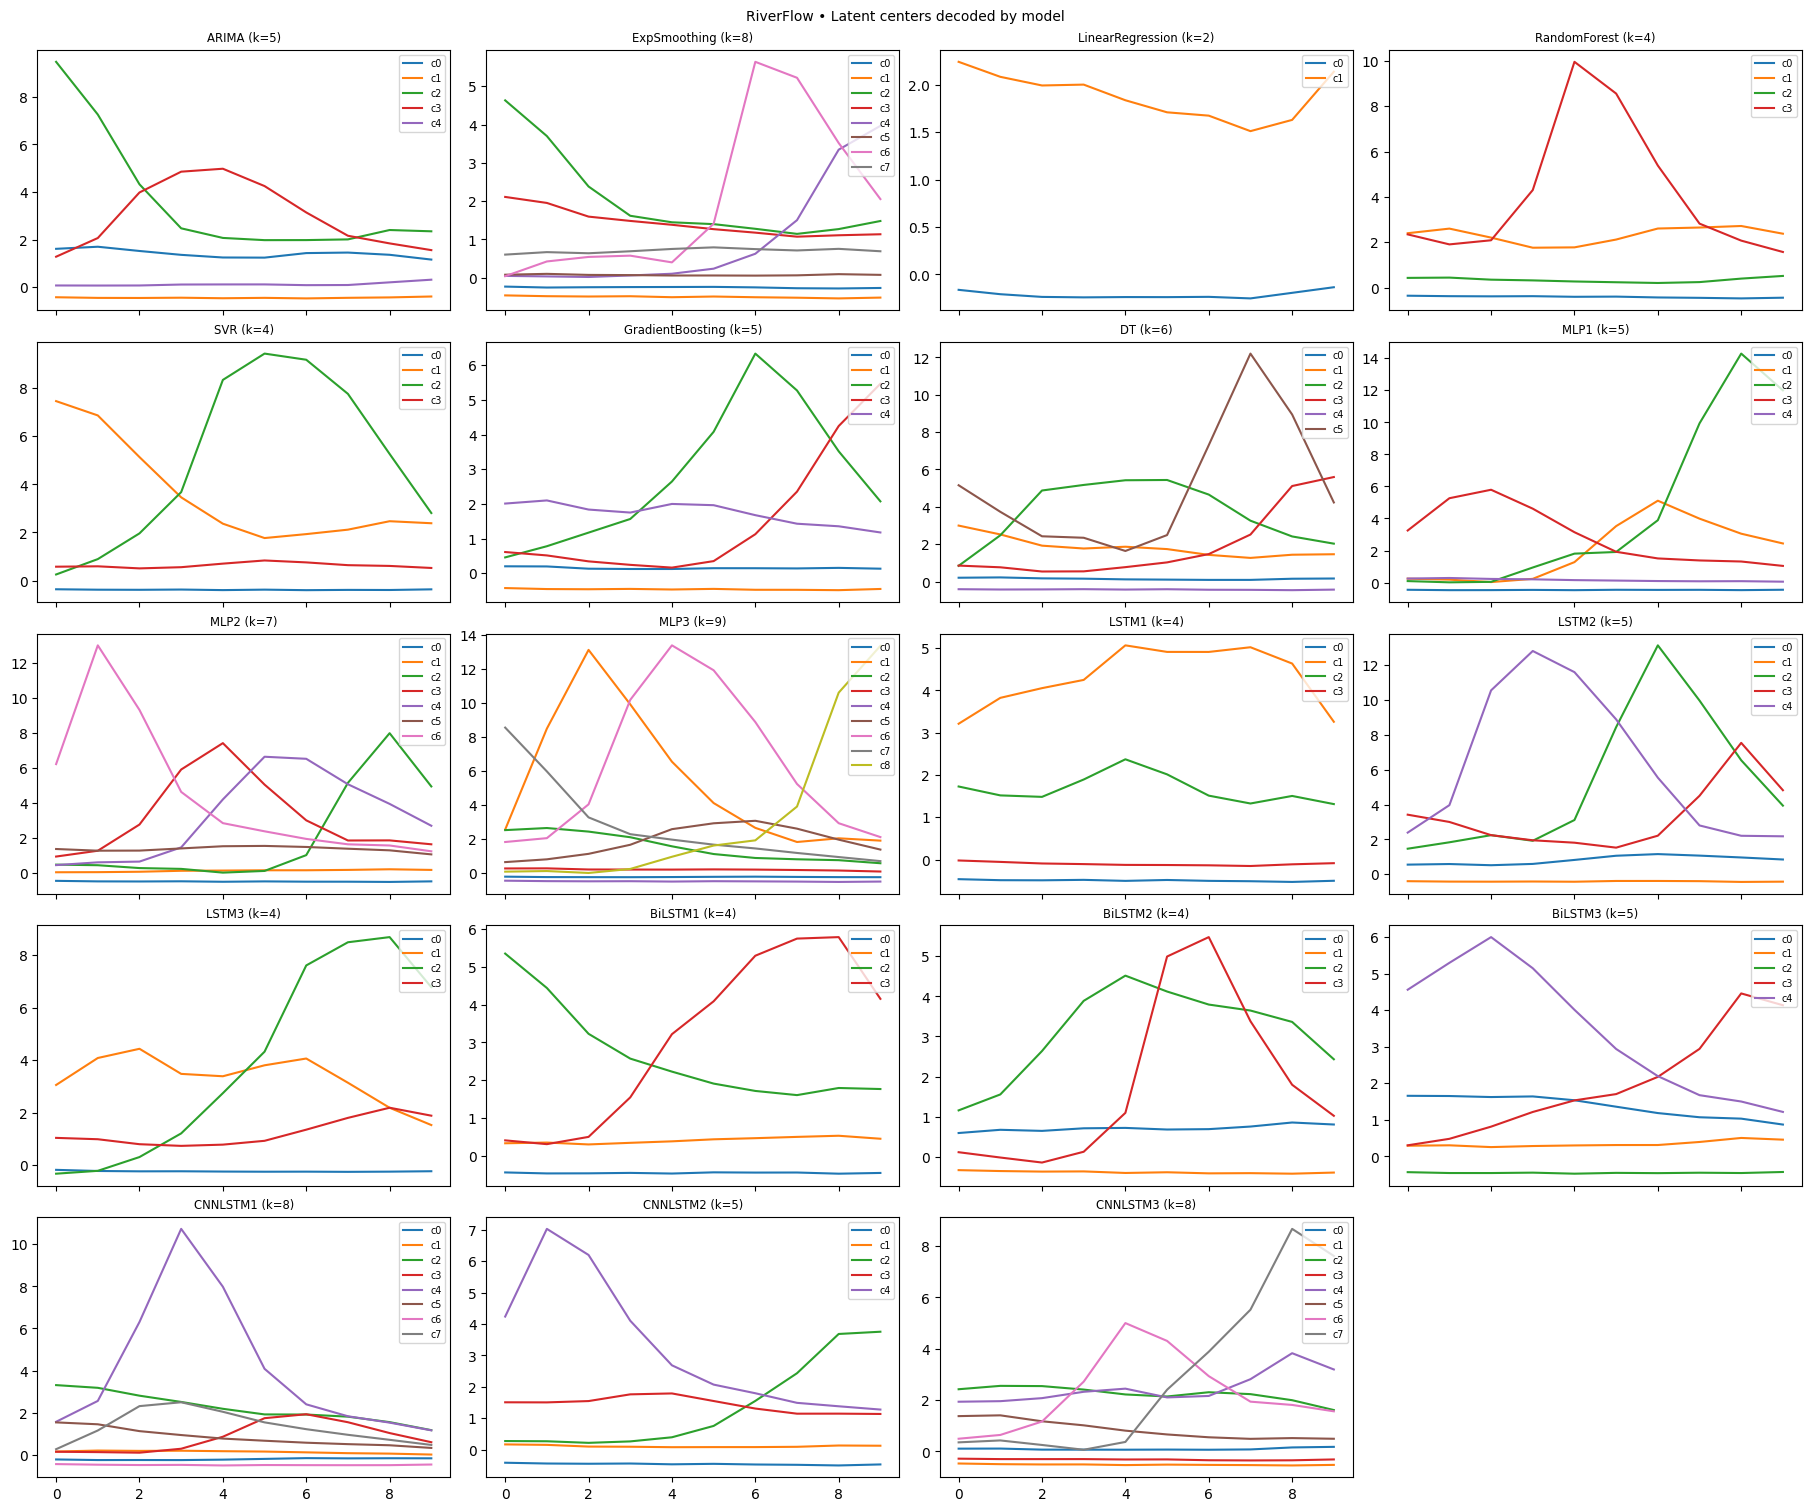


=== Compute K-means centers for Temperatures (window_size=10) ===


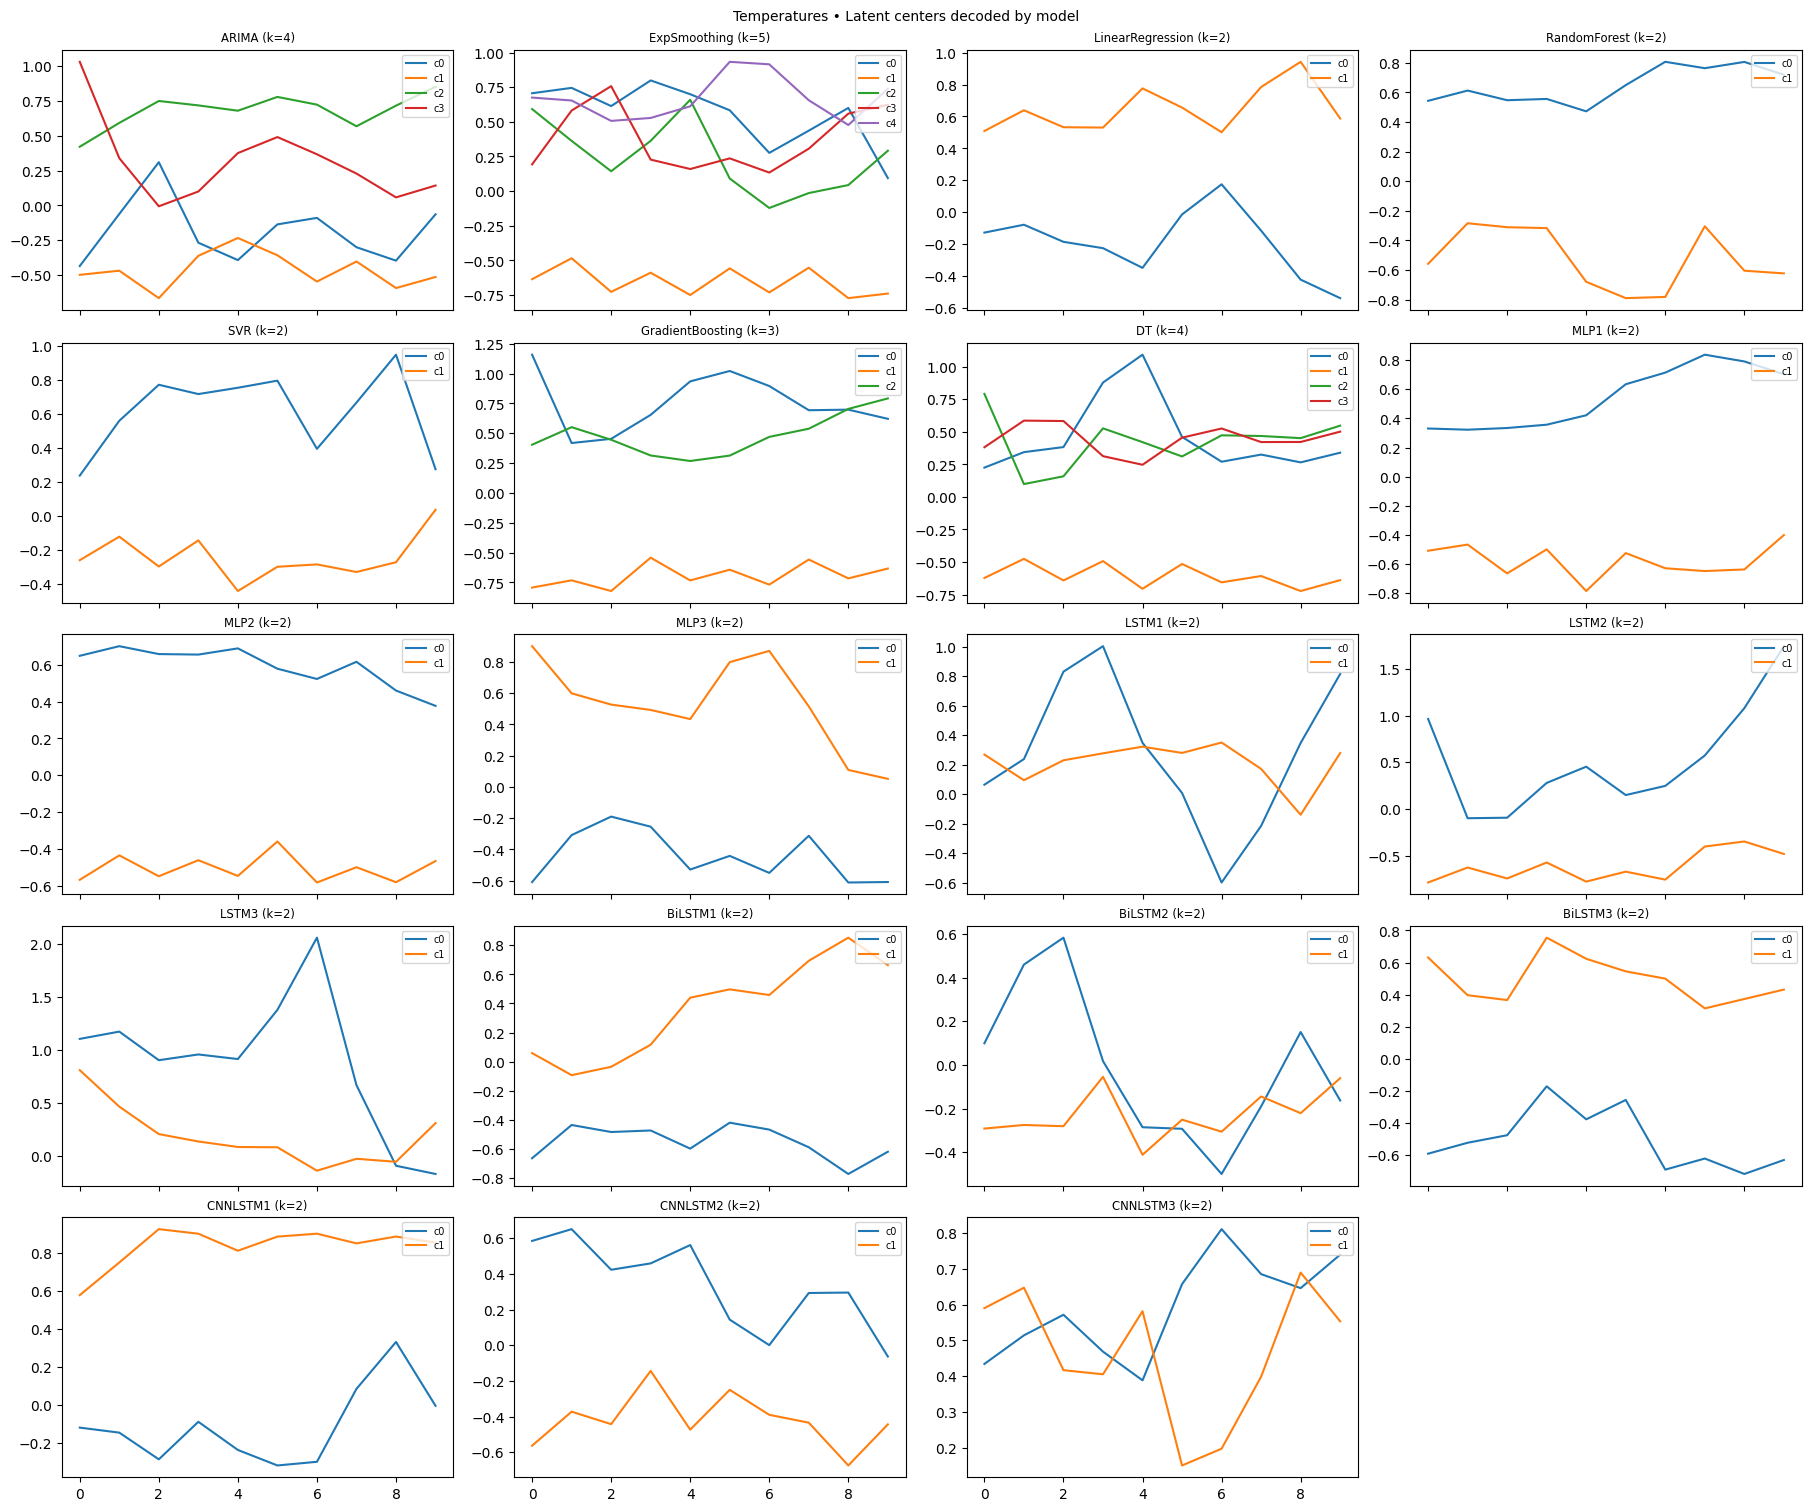


=== Compute K-means centers for Births (window_size=10) ===


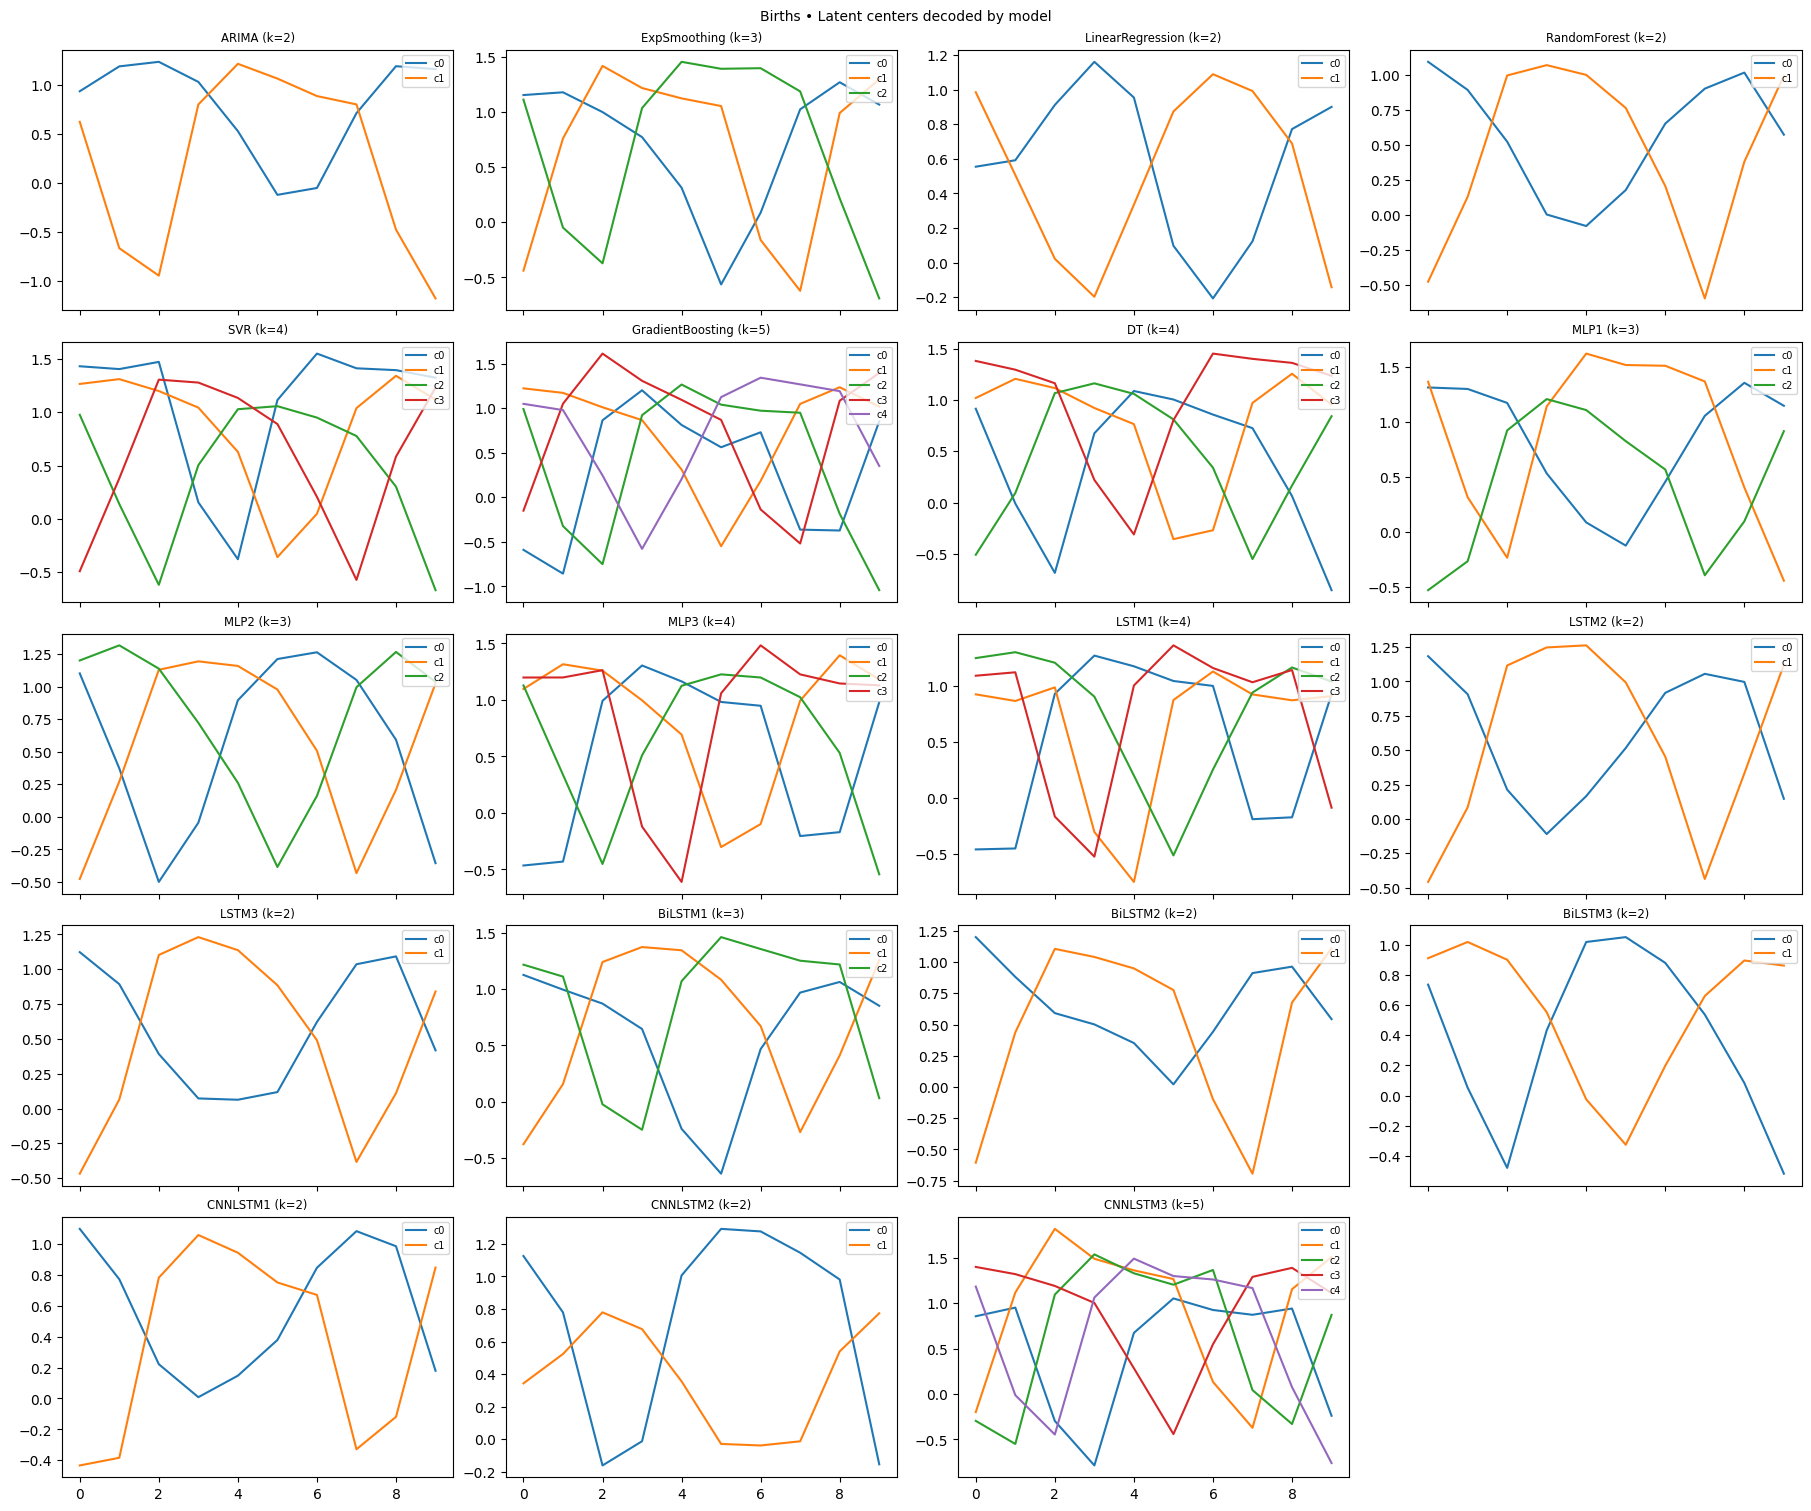

In [8]:
n_cols = 4
print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Compute K-means centers for {ds_name} (window_size={window_size}) ===")

    # Load models
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]

    # Clear previous centers
    for model in forecasters.values():
        model.centers = {"raw": [], "latent": []}

    # Determine device for decoding latent centers
    decoder_device = next(ae.decoder.parameters()).device

    for name, model in forecasters.items():
        # Cluster latent RoCs
        N_latent = len(model.rocs["latent"])
        if N_latent > 0:
            k_max_latent = np.sqrt(N_latent / 2)
            model.compute_kmeans_centers(mode="latent", k_max=k_max_latent, random_state=seed)

        # Cluster raw RoCs
        N_raw = len(model.rocs["raw"])
        if N_raw > 0:
            k_max_raw = np.sqrt(N_raw / 2)
            model.compute_kmeans_centers(mode="raw", k_max=k_max_raw, random_state=seed)

    # Plot all latent cluster centers (decoded)
    names = [n for n in forecasters if len(forecasters[n].centers["latent"]) > 0]
    n_models = len(names)
    if n_models == 0:
        print(" No models have centers to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, name in zip(axes, names):
        model = forecasters[name]
        for idx, c in enumerate(model.centers["latent"]):
            # ensure tensor on correct device
            c_tensor = c if isinstance(c, torch.Tensor) else torch.tensor(
                c, dtype=torch.float32
            )
            c_batch = c_tensor.unsqueeze(0).to(decoder_device)  # shape (1, C, L)
            decoded = ae.decoder(c_batch)                       # -> (1, 1, window_size)
            ts_data = decoded.detach().cpu().numpy().flatten()
            ax.plot(ts_data, label=f"c{idx}")
        ax.set_title(f"{name} (k={len(model.centers['latent'])})", fontsize="small")
        ax.legend(loc="upper right", fontsize="x-small")

    # turn off any unused subplots
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent centers decoded by model", fontsize="medium")
    plt.show()


### Latent Cluster Sampling

For each model, one latent cluster is selected. All windows assigned to that cluster are decoded and plotted in gray, with the decoded cluster center shown in black.


=== Plot latent cluster samples for Energy (compact grid) ===


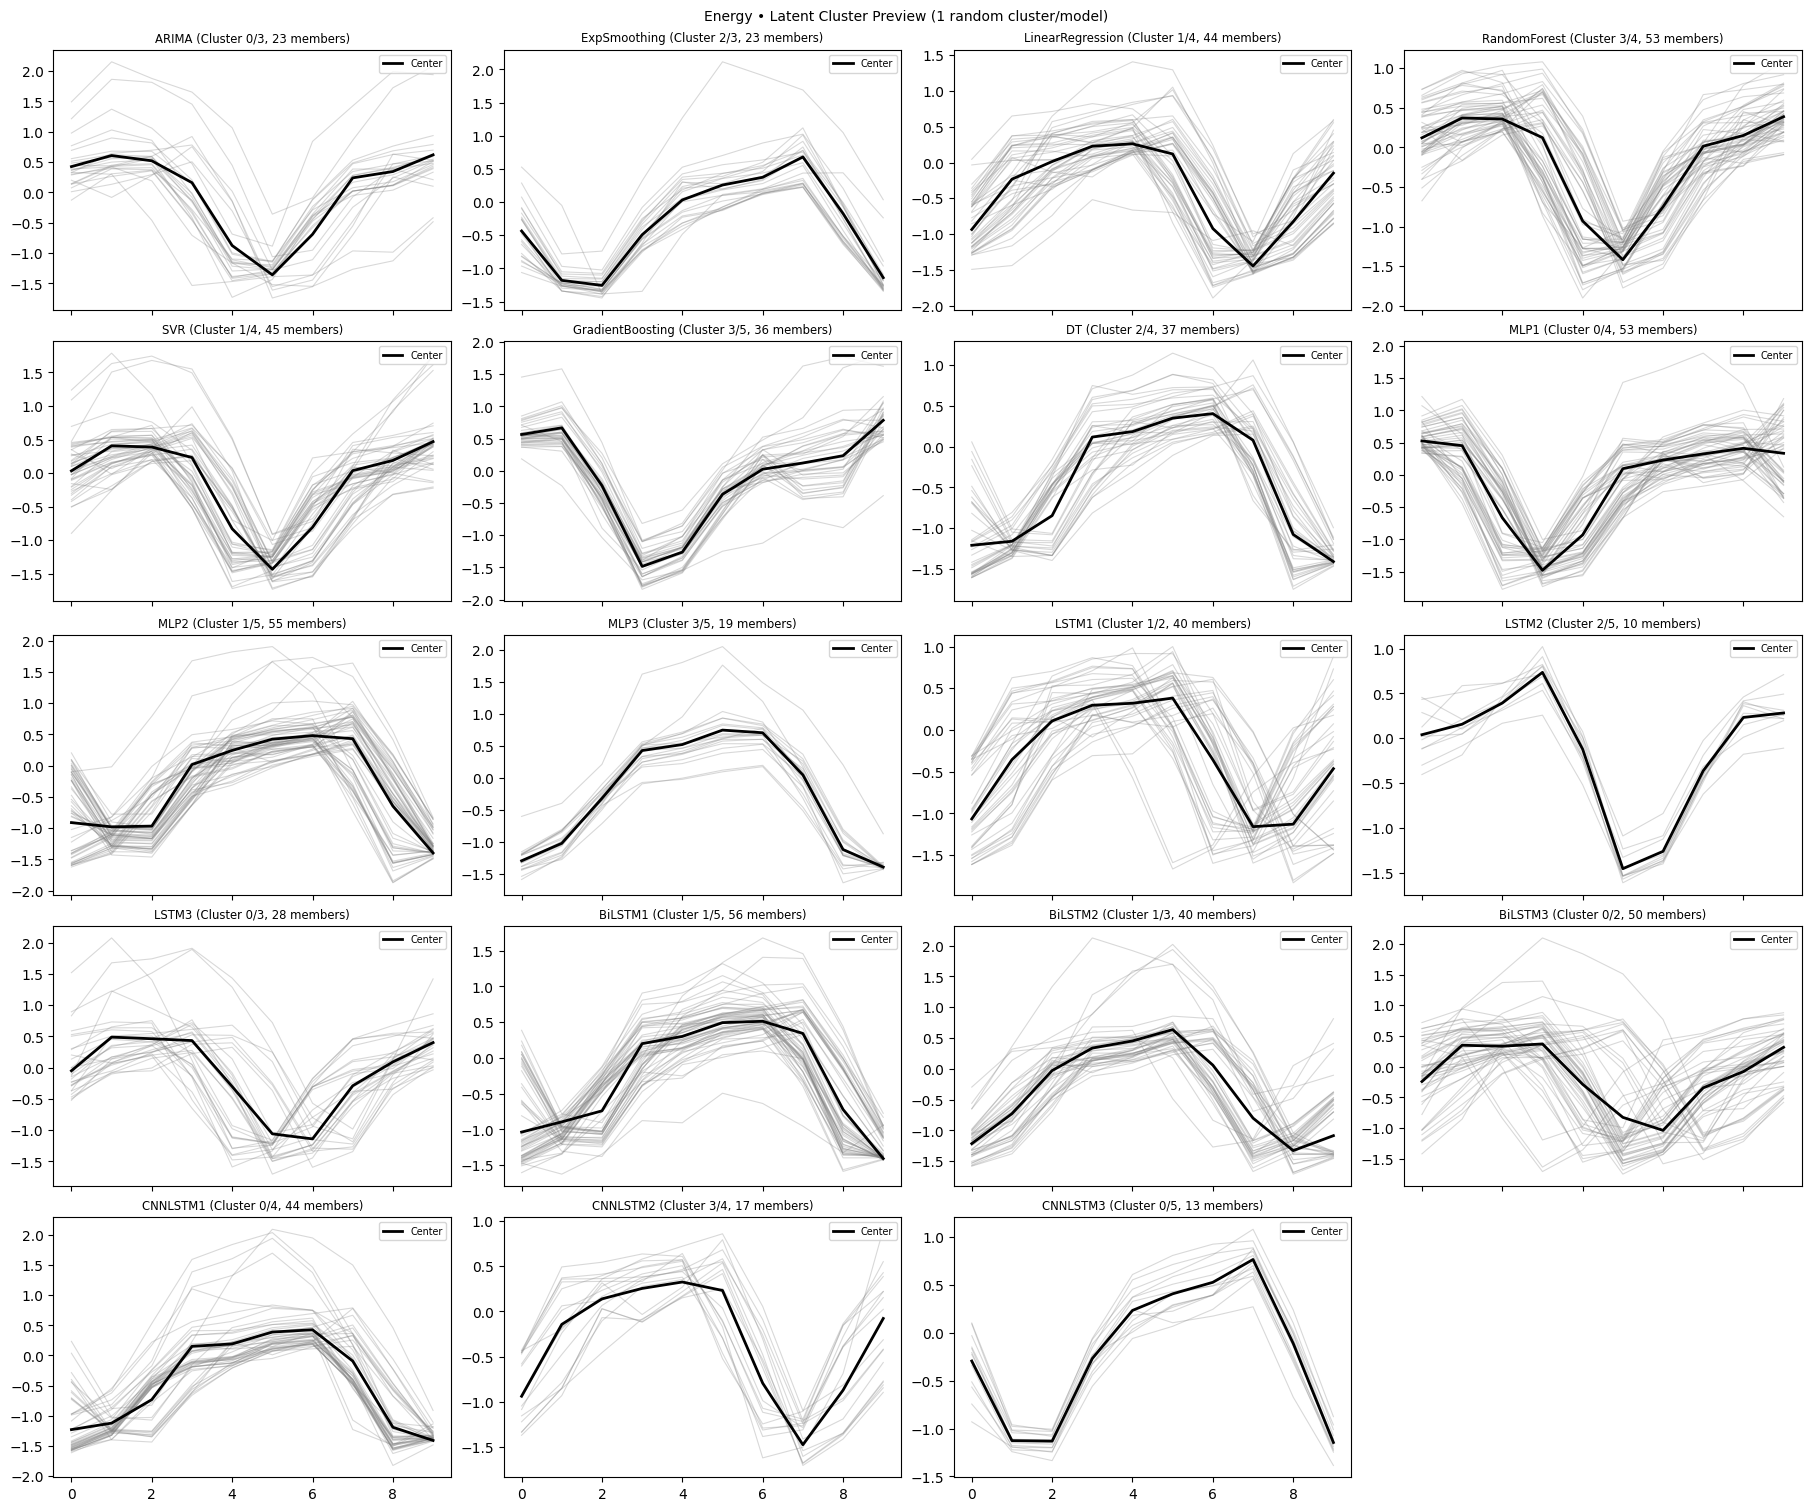


=== Plot latent cluster samples for RiverFlow (compact grid) ===


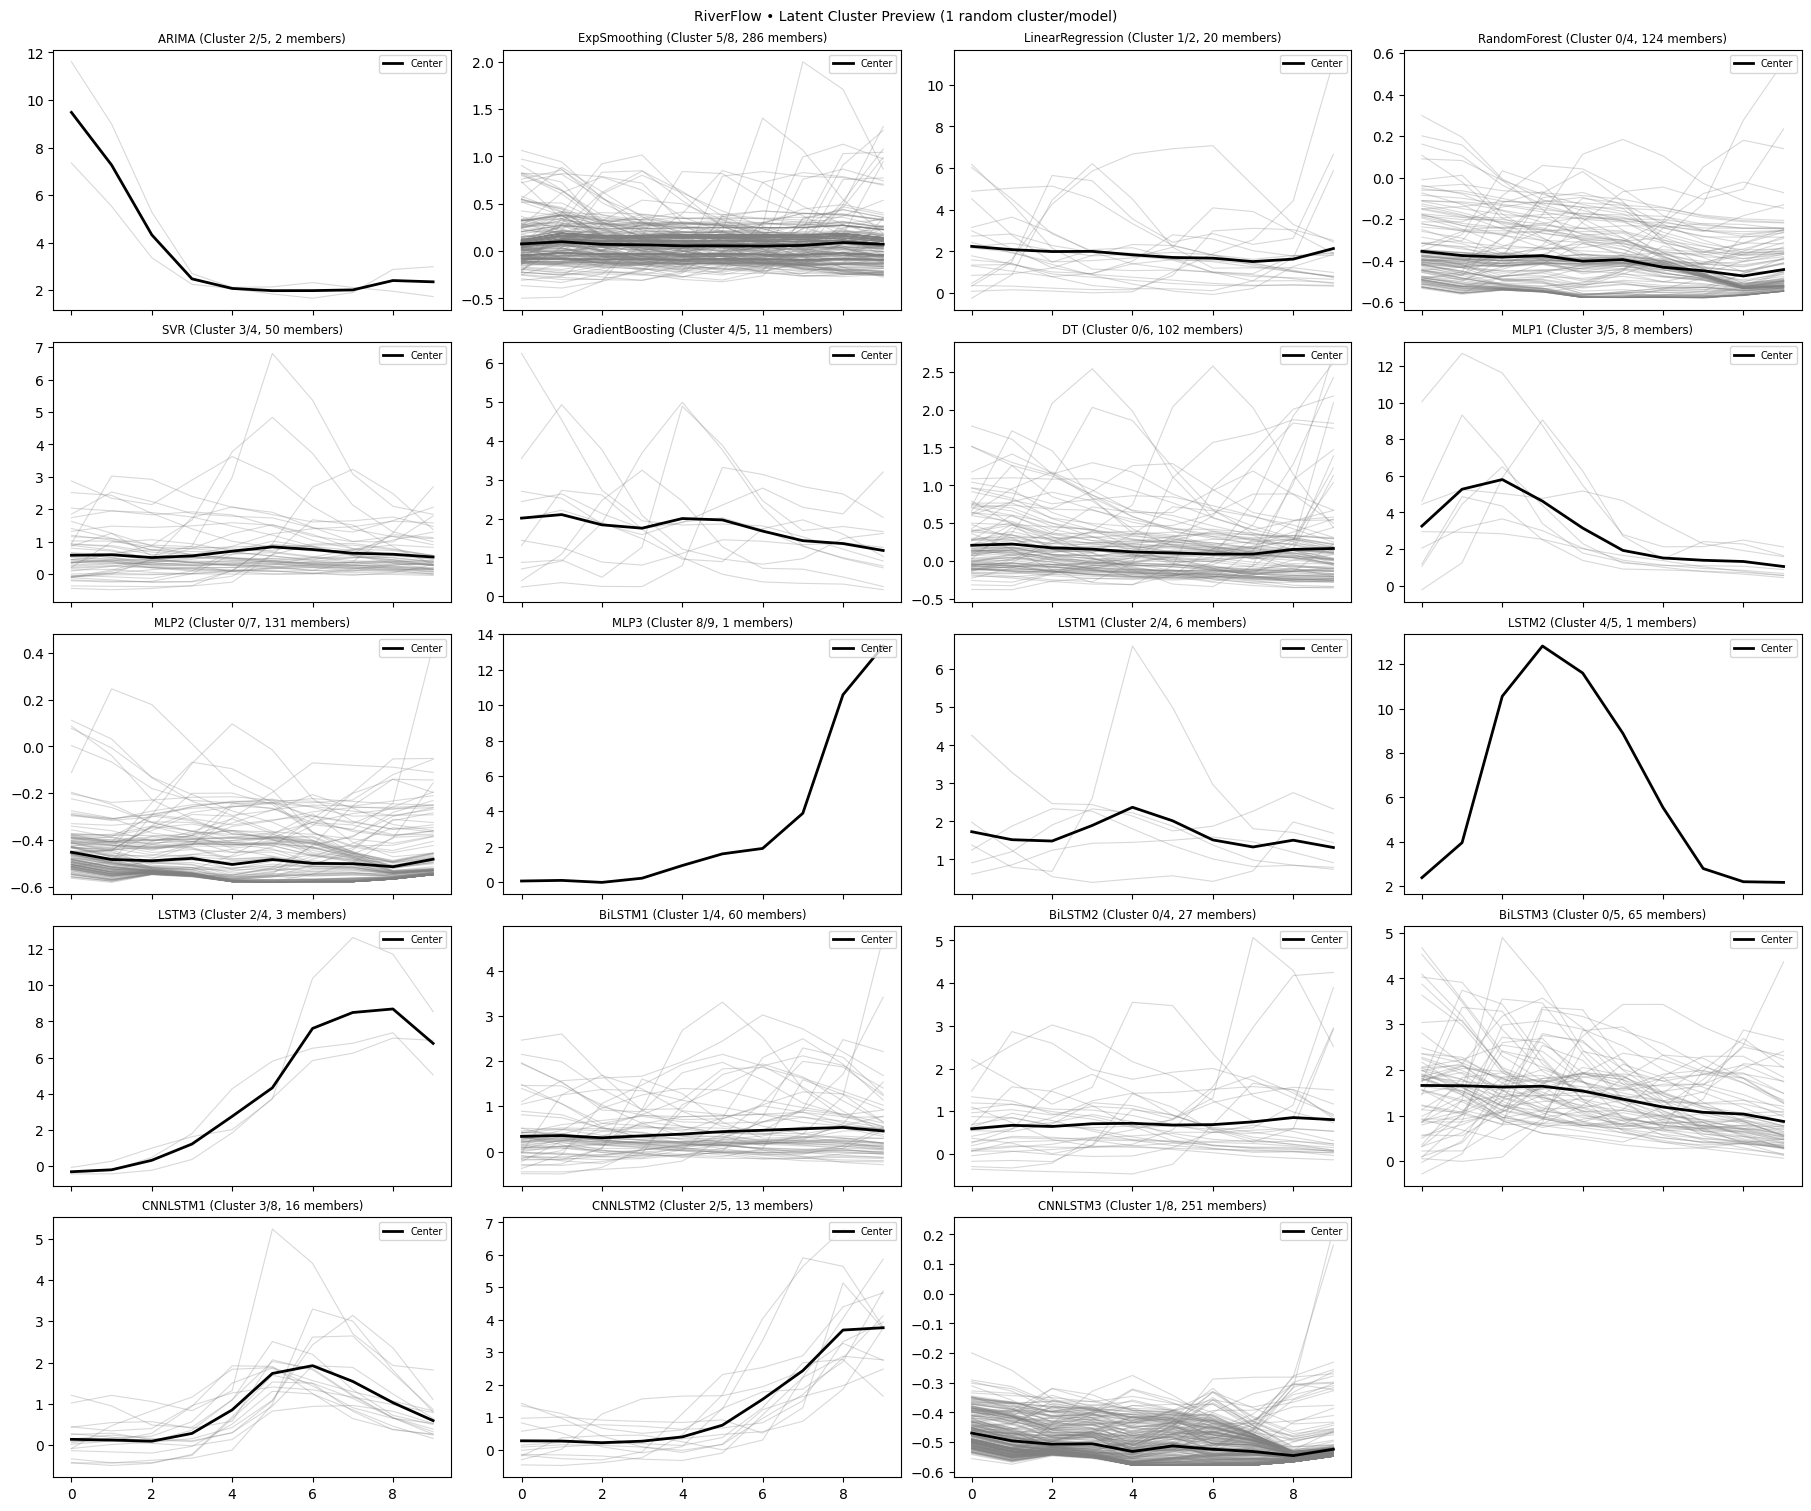


=== Plot latent cluster samples for Temperatures (compact grid) ===


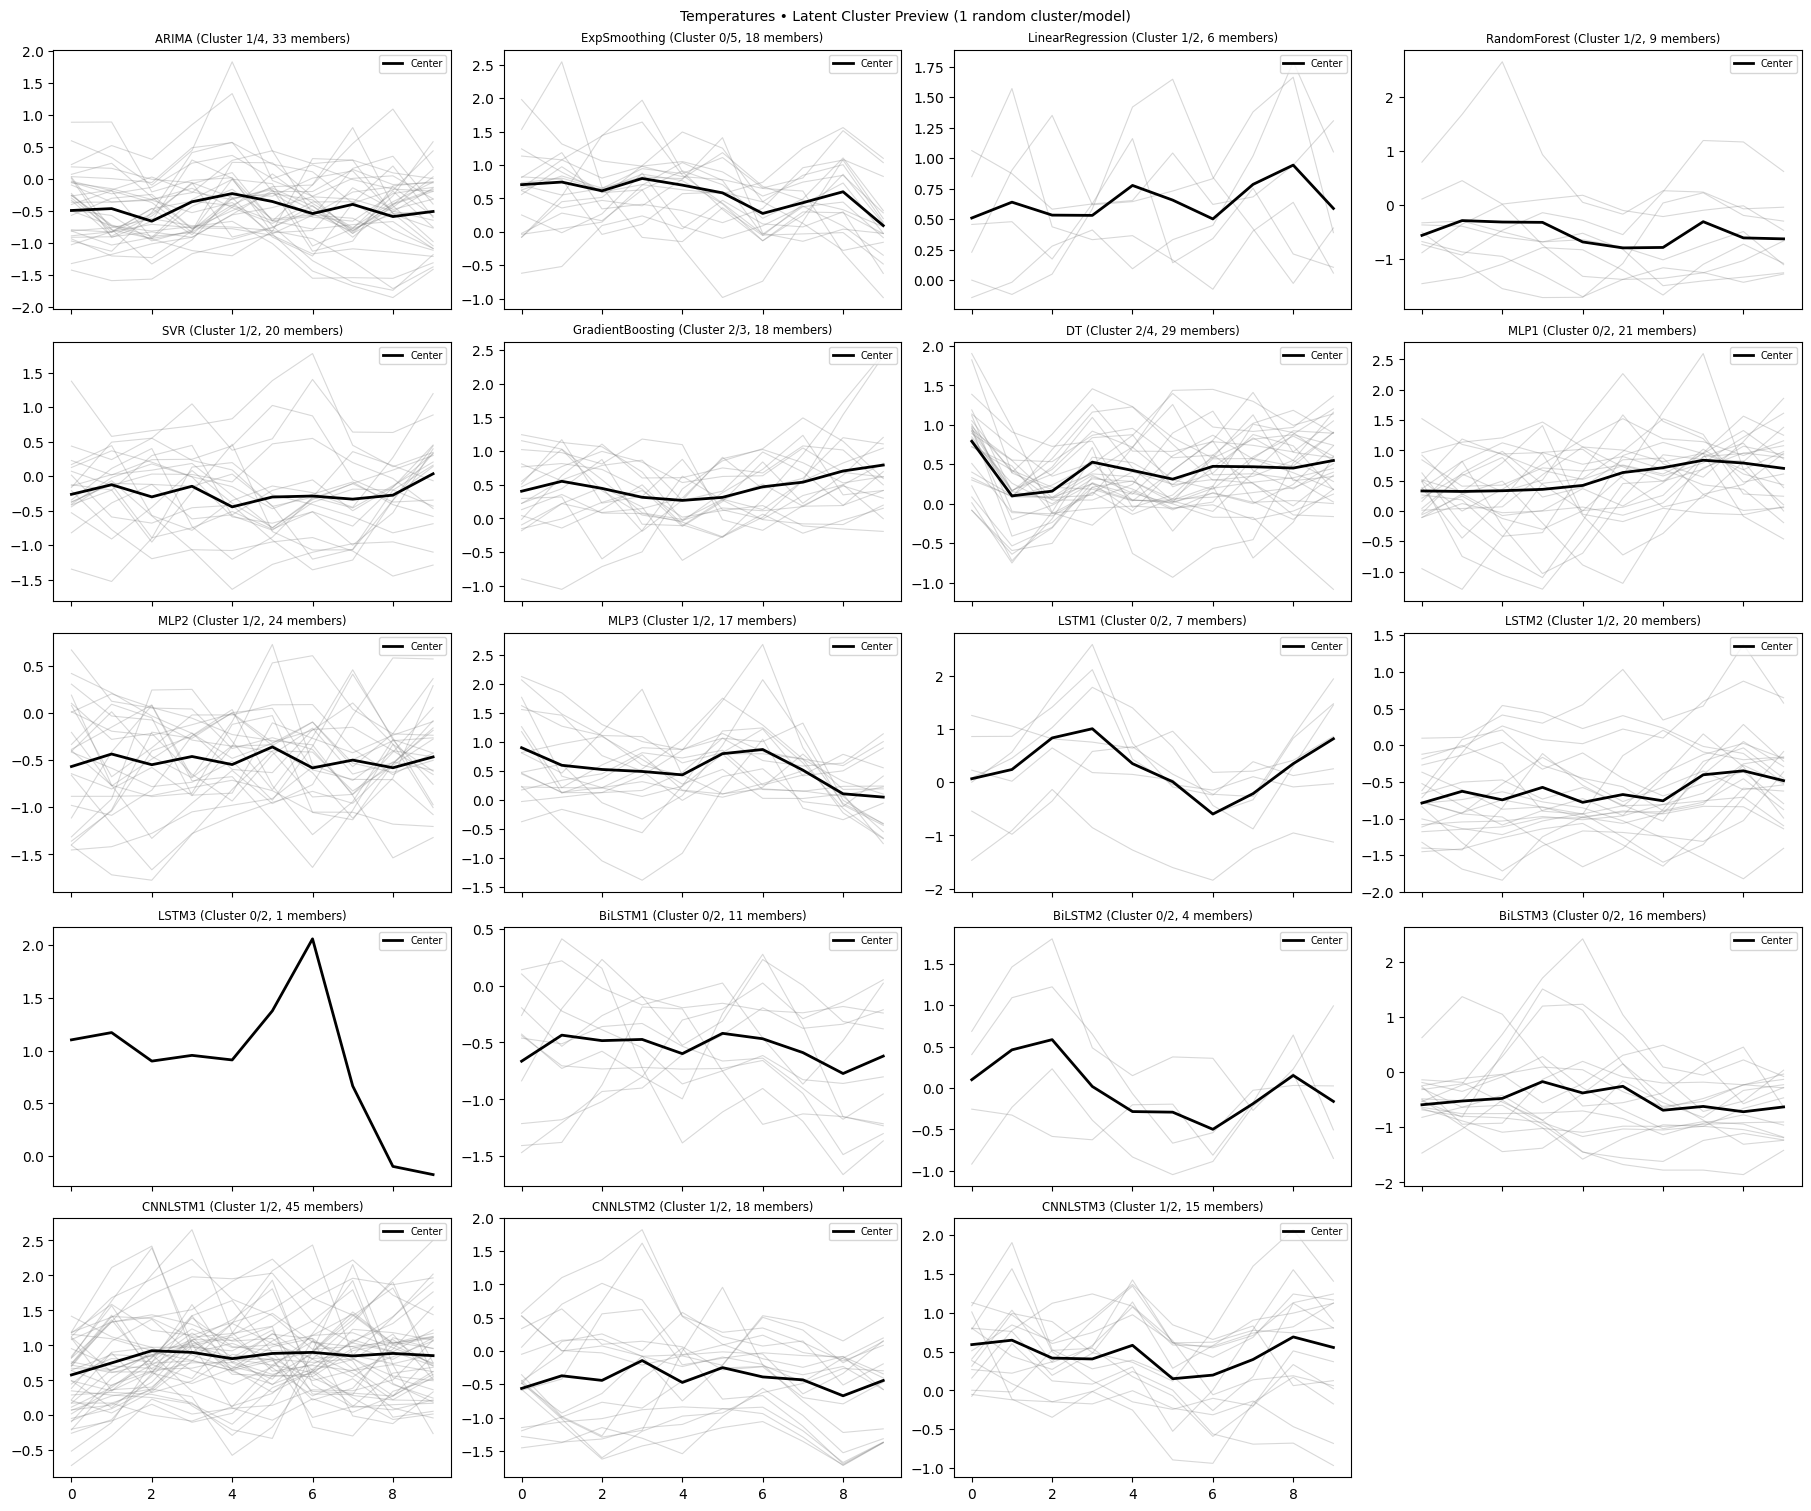


=== Plot latent cluster samples for Births (compact grid) ===


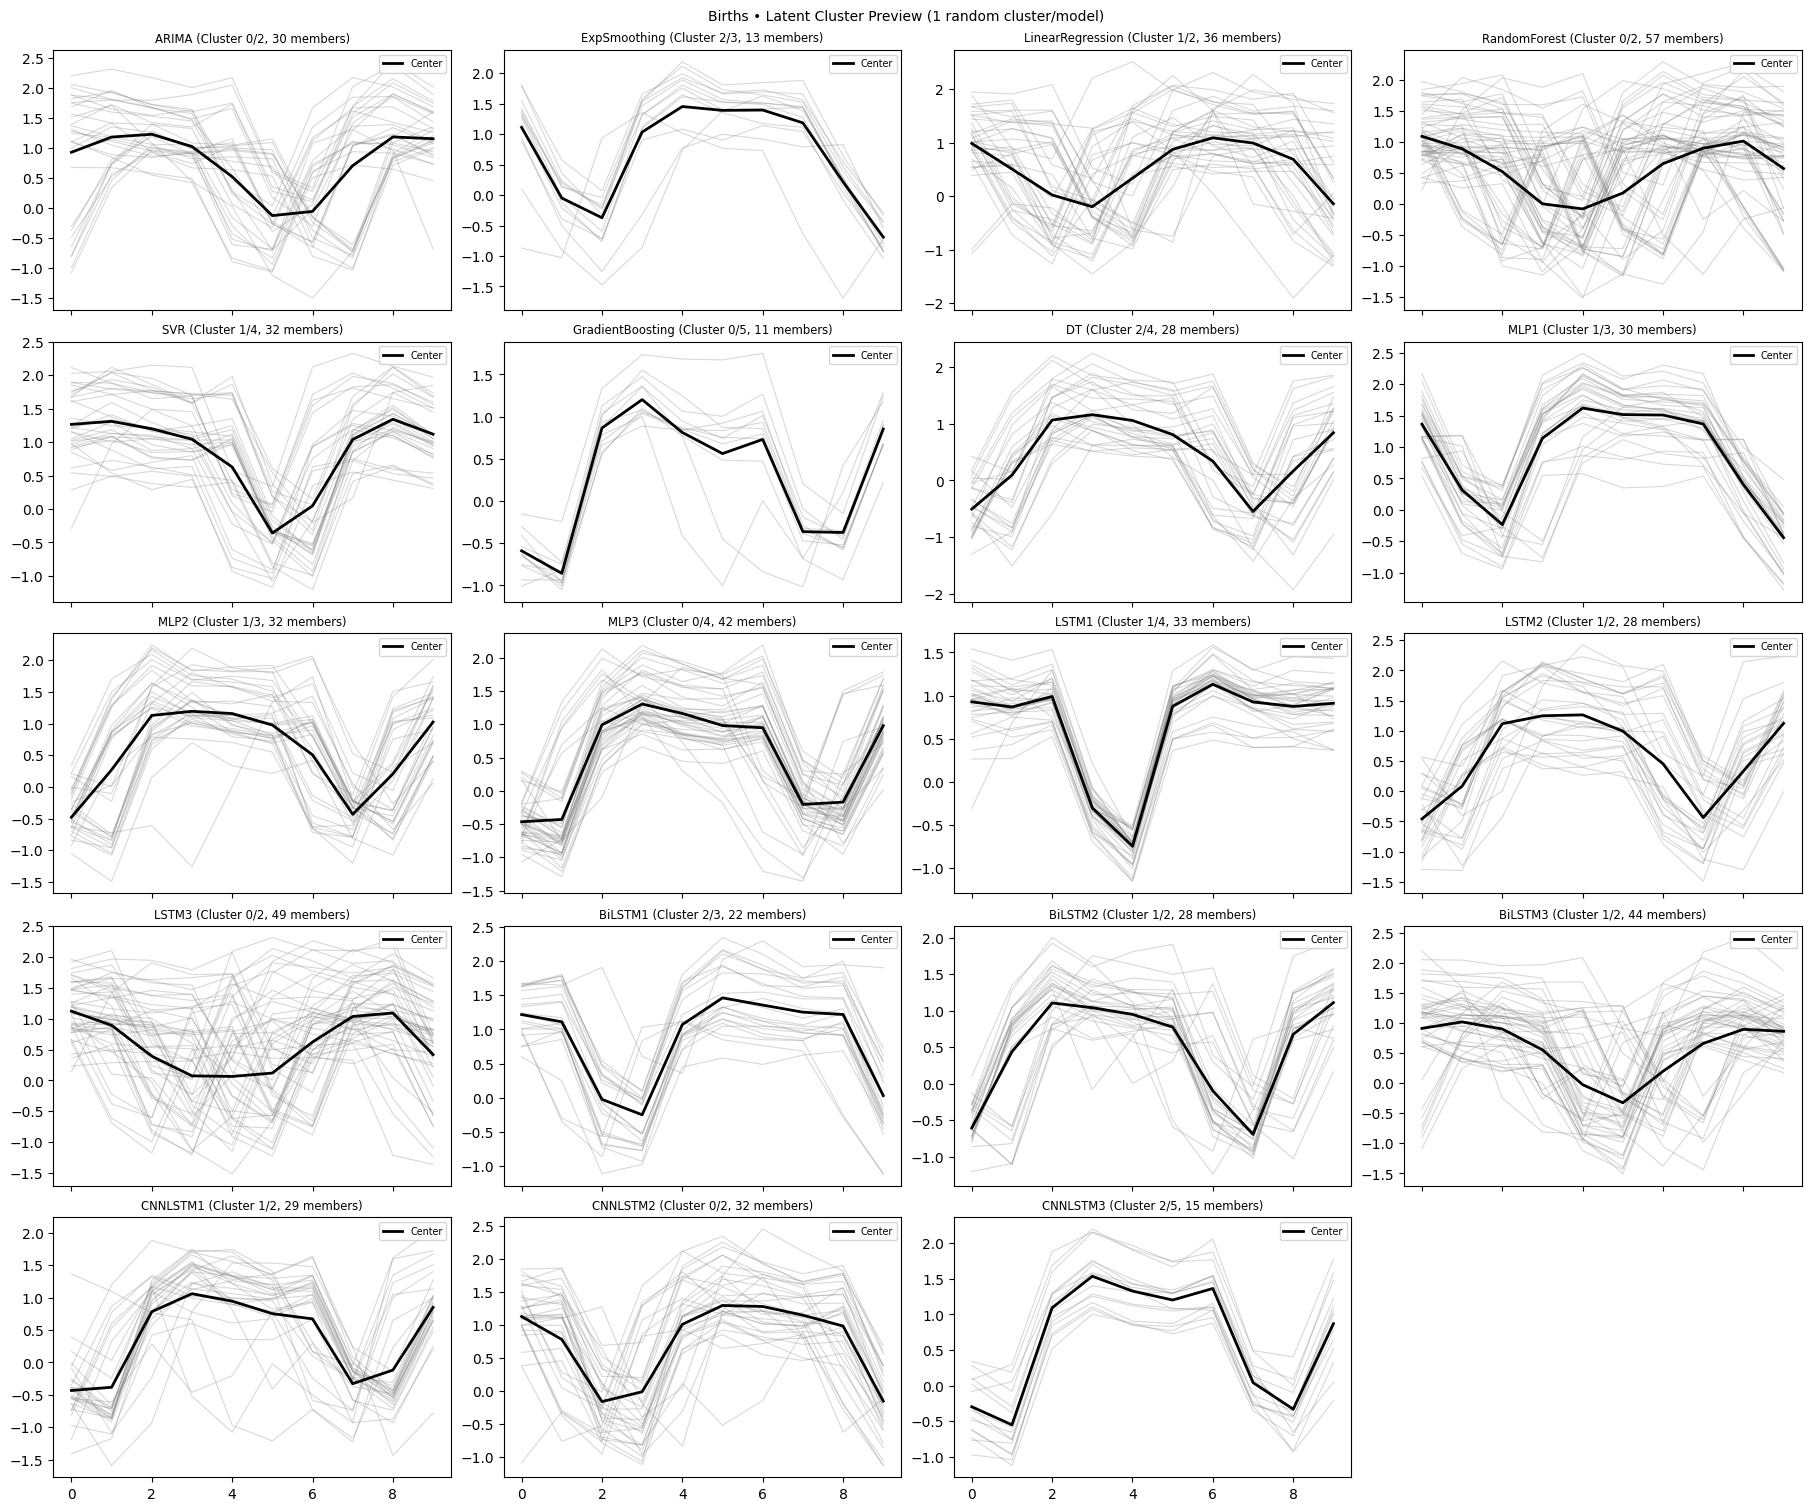

In [9]:
n_cols = 4
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Plot latent cluster samples for {ds_name} (compact grid) ===")

    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    decoder_device = next(ae.decoder.parameters()).device

    valid_models = []
    for name, model in forecasters.items():
        centers = model.centers["latent"]
        windows = model.rocs["latent"]

        if len(centers) == 0 or len(windows) == 0:
            continue

        # Flatten latent windows
        X = np.vstack([
            (w.detach().cpu().numpy() if isinstance(w, torch.Tensor) else np.array(w)).flatten()
            for w in windows
        ])

        # Flatten latent centers
        C = np.vstack([
            (c.detach().cpu().numpy() if isinstance(c, torch.Tensor) else np.array(c)).flatten()
            for c in centers
        ])

        # Use KMeans.predict with existing centers
        km = KMeans(n_clusters=len(C), init=C, n_init=1, max_iter=1, random_state=seed)
        labels = km.fit_predict(X)

        # Group windows by cluster
        cluster_to_indices = {i: [] for i in range(len(C))}
        for idx, label in enumerate(labels):
            cluster_to_indices[label].append(idx)

        valid_models.append((name, model, centers, cluster_to_indices, windows))

    n_models = len(valid_models)
    if n_models == 0:
        print(" No valid models to plot.")
        continue

    n_rows = math.ceil(n_models / n_cols)

    fig_width = n_cols * 4.5
    fig_height = n_rows * 3

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(fig_width, fig_height),
                             sharex=True, constrained_layout=True)
    axes = axes.flatten()

    for ax, (name, model, centers, cluster_to_indices, windows) in zip(axes, valid_models):
        non_empty_clusters = [i for i, idxs in cluster_to_indices.items() if len(idxs) > 0]
        if not non_empty_clusters:
            ax.set_title(f"{name} (no populated clusters)", fontsize="small")
            ax.axis("off")
            continue

        chosen_c = random.choice(non_empty_clusters)
        member_indices = cluster_to_indices[chosen_c]

        for i in member_indices:
            w_tensor = windows[i].unsqueeze(0).to(decoder_device)
            decoded = ae.decoder(w_tensor).detach().cpu().numpy().flatten()
            ax.plot(decoded, alpha=0.3, linewidth=0.8, color='gray')

        c_tensor = centers[chosen_c].unsqueeze(0).to(decoder_device)
        decoded_center = ae.decoder(c_tensor).detach().cpu().numpy().flatten()
        ax.plot(decoded_center, color='black', linewidth=2, label="Center")

        ax.set_title(
            f"{name} (Cluster {chosen_c}/{len(centers)}, {len(member_indices)} members)",
            fontsize="small"
        )
        ax.legend(loc="upper right", fontsize="x-small")

    # Turn off unused axes
    for ax in axes[n_models:]:
        ax.axis("off")

    plt.suptitle(f"{ds_name} • Latent Cluster Preview (1 random cluster/model)",
                 fontsize="medium")
    plt.show()

## RQ1: Latent vs. Raw Space for Model Selection Across Distance Metrics

The goal is to compare the effectiveness of model selection based on similarity in latent space via autoencoder embeddings versus raw time-domain. This comparison is conducted across multiple distance measures, including Euclidean, Cosine, Manhattan and Dynamic Time Warping applied in both raw and latent spaces.

### Test 1.1: Forecasting MSE Comparison

We compare one-step-ahead forecasting error (MSE) when selecting forecaster in raw vs. latent space using three distance metrics. For each, lower MSE from latent-space selection indicates that the latent embedding preserves meaningful similarity under the corresponding metric. 

In [10]:
# Lists to collect detailed disagreements, high-level summaries, and neighbor sets
disagreements = []
summary_list = []
neighbor_data = []

# Ensure a clean results/ directory
if os.path.exists(RESULTS_DIR):
    shutil.rmtree(RESULTS_DIR)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Bottleneck size: {latent_dim}")

for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # Load data
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load forecasters
    ae = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows = len(X_test)

    for metric in metrics_list:
        # prepare neighbor-set collectors
        raw_neighbor_sets = []
        lat_neighbor_sets = []

        # ---- RAW inference ----
        t0 = time.perf_counter()
        raw_preds, raw_models = [], []
        for w in X_test:
            q = w
            best_name, best_dist = None, float("inf")
            window_dists = []
            for name, model in forecasters.items():
                for entry in model.rocs["raw"]:
                    d = compute_distance(q, entry, metric=metric)
                    window_dists.append((d, name))
                    if d < best_dist:
                        best_dist, best_name = d, name
            raw_models.append(best_name)
            window_dists.sort(key=lambda x: x[0])
            raw_neighbor_sets.append([name for _, name in window_dists[:5]])
            raw_preds.append(forecasters[best_name].predict(w))
        time_raw = time.perf_counter() - t0
        mse_raw  = mean_squared_error(y_test, raw_preds)

        # ---- LATENT inference ----
        t1 = time.perf_counter()
        lat_preds, lat_models = [], []
        for w in X_test:
            with torch.no_grad():
                q = ae.encode(w).cpu()
            best_name, best_dist = None, float("inf")
            window_dists = []
            for name, model in forecasters.items():
                for entry in model.rocs["latent"]:
                    d = compute_distance(q, entry, metric=metric)
                    window_dists.append((d, name))
                    if d < best_dist:
                        best_dist, best_name = d, name
            lat_models.append(best_name)
            window_dists.sort(key=lambda x: x[0])
            lat_neighbor_sets.append([name for _, name in window_dists[:5]])
            lat_preds.append(forecasters[best_name].predict(w))
        time_lat = time.perf_counter() - t1
        mse_lat  = mean_squared_error(y_test, lat_preds)

        # ---- Record neighbor‐sets for later Jaccard analysis ----
        for idx in range(n_windows):
            neighbor_data.append({
                "dataset":       ds_name,
                "metric":        metric,
                "win_idx":       idx,
                "raw_neighbors": raw_neighbor_sets[idx],
                "lat_neighbors": lat_neighbor_sets[idx],
            })

        # ---- Record disagreements ----
        n_dis = 0
        for idx, (rm, lm, yt, pr, pl) in enumerate(zip(raw_models, lat_models, y_test, raw_preds, lat_preds)):
            if rm != lm:
                n_dis += 1
                disagreements.append({
                    "dataset":      ds_name,
                    "metric":       metric,
                    "win_idx":      idx,
                    "raw_model":    rm,
                    "lat_model":    lm,
                    "y_true":       yt,
                    "y_pred_raw":   pr,
                    "y_pred_lat":   pl,
                })
        rate = n_dis / n_windows

        # ---- Append summary ----
        summary_list.append({
            "dataset":          ds_name,
            "metric":           metric,
            "test_mse_raw":     mse_raw,
            "test_mse_lat":     mse_lat,
            "time_raw":         time_raw,
            "time_lat":         time_lat,
            "n_disagreements":  n_dis,
            "disagreement_rate":rate,
        })

        # ---- Print results ----
        print(
            f"[{metric:^9}] "
            f"raw MSE={mse_raw:.4f}@{time_raw:.2f}s | "
            f"lat MSE={mse_lat:.4f}@{time_lat:.2f}s | "
            f"dis={n_dis}/{n_windows} ({rate:.2%})  | "
            f"%‐improvement: {1 - mse_lat/mse_raw:.2%}"
        )

# Build DataFrames and save
df_dis = pd.DataFrame(disagreements)
df_sum = pd.DataFrame(summary_list)
df_nei = pd.DataFrame(neighbor_data)

df_dis.to_csv("results/disagreements.csv", index=False)
df_sum.to_csv("results/validation.csv",    index=False)
df_nei.to_csv("results/neighbor_sets.csv", index=False)

Bottleneck size: 2

=== Dataset: Energy ===
[   dtw   ] raw MSE=0.0559@231.63s | lat MSE=0.0523@286.49s | dis=1945/2913 (66.77%)  | %‐improvement: 6.37%
[euclidean] raw MSE=0.0465@21.38s | lat MSE=0.0501@53.74s | dis=1594/2913 (54.72%)  | %‐improvement: -7.67%
[ cosine  ] raw MSE=0.0426@38.39s | lat MSE=0.0544@127.90s | dis=1823/2913 (62.58%)  | %‐improvement: -27.79%
[manhattan] raw MSE=0.0472@27.12s | lat MSE=0.0499@56.96s | dis=1712/2913 (58.77%)  | %‐improvement: -5.73%

=== Dataset: RiverFlow ===
[   dtw   ] raw MSE=0.1005@946.08s | lat MSE=0.0936@1139.84s | dis=4237/5926 (71.50%)  | %‐improvement: 6.85%
[euclidean] raw MSE=0.1022@81.53s | lat MSE=0.0987@201.68s | dis=2966/5926 (50.05%)  | %‐improvement: 3.40%
[ cosine  ] raw MSE=0.1037@156.47s | lat MSE=0.0911@502.55s | dis=4766/5926 (80.43%)  | %‐improvement: 12.11%
[manhattan] raw MSE=0.1011@107.56s | lat MSE=0.0963@217.90s | dis=3054/5926 (51.54%)  | %‐improvement: 4.75%

=== Dataset: Temperatures ===
[   dtw   ] raw MSE=0.341

### Test 1.2: Win Rate Analysis

For each metric, we compute the win-rate as the fraction of windows where the latent-space model outperforms the raw model . A win-rate above 50% indicates more frequent wins for the latent model. This analysis complements MSE results to explore whether performance gains arise from consistent small wins or a few large ones.

In [11]:
print(f"Bottleneck size: {latent_dim}")

df_dis['raw_error'] = (df_dis['y_pred_raw'] - df_dis['y_true'])**2
df_dis['lat_error'] = (df_dis['y_pred_lat'] - df_dis['y_true'])**2
df_dis['winner'] = np.where(df_dis['lat_error'] < df_dis['raw_error'],
                            'latent', 'raw')

# Count wins among disagreements
win_counts = (
    df_dis
    .groupby(['dataset','metric','winner'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_wins','latent':'latent_wins'})
)

# Compute win‐rates (conditional on disagreement)
win_rates = win_counts.div(win_counts.sum(axis=1), axis=0) \
                      .rename(columns={'raw_wins':'raw_win_rate',
                                       'latent_wins':'latent_win_rate'})

# Merge rates into the summary table
df_full = (
    df_sum
    .merge(win_rates.reset_index(), on=['dataset','metric'], how='left')
    .fillna(0)
    .assign(
        same_decision_rate = 1 - df_sum['disagreement_rate']
    )
)

# Display results
display(
    df_full[[
        'dataset','metric',
        'raw_win_rate','latent_win_rate','same_decision_rate'
    ]]
)

# Save for later
win_rates.to_csv("results/win_rates.csv", index=False)

Bottleneck size: 2


dataset     metric  raw_win_rate  latent_win_rate  same_decision_rate
0         Energy        dtw      0.483805         0.516195            0.332303
1         Energy  euclidean      0.525094         0.474906            0.452798
2         Energy     cosine      0.555129         0.444871            0.374185
3         Energy  manhattan      0.502921         0.497079            0.412290
4      RiverFlow        dtw      0.493274         0.506726            0.285015
5      RiverFlow  euclidean      0.514498         0.485502            0.499494
6      RiverFlow     cosine      0.520352         0.479648            0.195748
7      RiverFlow  manhattan      0.500982         0.499018            0.484644
8   Temperatures        dtw      0.476712         0.523288            0.191584
9   Temperatures  euclidean      0.498355         0.501645            0.326689
10  Temperatures     cosine      0.506531         0.493469            0.236988
11  Temperatures  manhattan      0.488599         0.511401            0.320044
12        Births        dtw      0.447541         0.552459            0.328564
13        Births  euclidean      0.468227         0.531773            0.506329
14        Births     cosine      0.486672         0.513328            0.277380
15        Births  manhattan      0.476828         0.523172            0.465603

To complement the unweighted win-rate analysis, we compute weighted win rates that account for the magnitude of prediction errors. For each window, we calculate the mean squared error (MSE) for both the latent and raw models, and assign a weight equal to the larger of the two errors. The “winner” for each window is determined based on which model yields the lower MSE. We then sum these weights separately for the latent and raw models across all windows and compute each model’s share of the total weight, yielding a weighted win rate. 

This approach emphasizes not just how often a model wins, but how significant its wins are—highlighting whether improvements arise from consistent small gains or occasional large differences.

In [12]:
print(f"Bottleneck size: {latent_dim}")

# Compute per-window errors and weights
df_dis['mse_raw']    = (df_dis['y_pred_raw']   - df_dis['y_true'])**2
df_dis['mse_latent'] = (df_dis['y_pred_lat']   - df_dis['y_true'])**2
df_dis['weight']     = df_dis[['mse_raw','mse_latent']].max(axis=1)

# --- 2. Determine per-window “winner” ---
df_dis['winner'] = np.where(
    df_dis['mse_latent'] < df_dis['mse_raw'],
    'latent', 'raw'
)

# Sum weights by dataset, metric, and winner
weight_sums = (
    df_dis
    .groupby(['dataset','metric','winner'])['weight']
    .sum()
    .unstack(fill_value=0)
    .rename(columns={'raw':'raw_weight','latent':'latent_weight'})
)

# Compute weighted win‐rates
weighted_win_rates = (
    weight_sums
    .div(weight_sums.sum(axis=1), axis=0)
    .rename(columns={
        'raw_weight':    'raw_weighted_win_rate',
        'latent_weight': 'latent_weighted_win_rate'
    })
)

# Merge into the summary and compute same_decision_rate
df_full = (
    df_sum
    .merge(weighted_win_rates.reset_index(), on=['dataset','metric'], how='left')
    .assign(same_decision_rate = 1 - df_sum['disagreement_rate'])
)

# Save
display(df_full[[
    'dataset','metric',
    'raw_weighted_win_rate',
    'latent_weighted_win_rate',
    'same_decision_rate'
]])

weighted_win_rates.to_csv("results/weighted_win_rates.csv")

Bottleneck size: 2


dataset     metric  raw_weighted_win_rate  latent_weighted_win_rate  \
0         Energy        dtw               0.468374                  0.531626   
1         Energy  euclidean               0.545294                  0.454706   
2         Energy     cosine               0.645638                  0.354362   
3         Energy  manhattan               0.561184                  0.438816   
4      RiverFlow        dtw               0.408029                  0.591971   
5      RiverFlow  euclidean               0.447319                  0.552681   
6      RiverFlow     cosine               0.428996                  0.571004   
7      RiverFlow  manhattan               0.443246                  0.556754   
8   Temperatures        dtw               0.460451                  0.539549   
9   Temperatures  euclidean               0.494760                  0.505240   
10  Temperatures     cosine               0.491031                  0.508969   
11  Temperatures  manhattan               0.493815                  0.506185   
12        Births        dtw               0.348905                  0.651095   
13        Births  euclidean               0.383228                  0.616772   
14        Births     cosine               0.468541                  0.531459   
15        Births  manhattan               0.487228                  0.512772   

    same_decision_rate  
0             0.332303  
1             0.452798  
2             0.374185  
3             0.412290  
4             0.285015  
5             0.499494  
6             0.195748  
7             0.484644  
8             0.191584  
9             0.326689  
10            0.236988  
11            0.320044  
12            0.328564  
13            0.506329  
14            0.277380  
15            0.465603

### Test 1.3: Neighbor-Set Overlap

For each window $w$, let $N_{\mathrm{raw}}(w)$ and $N_{\mathrm{lat}}(w)$ be its top-$k$ forecasters under raw vs. latent distances. Define the Jaccard index

$$
J(w) \;=\; \frac{\lvert N_{\mathrm{raw}}(w)\,\cap\,N_{\mathrm{lat}}(w)\rvert}{\lvert N_{\mathrm{raw}}(w)\,\cup\,N_{\mathrm{lat}}(w)\rvert},
$$

and the mean overlap

$$
\bar J \;=\; \frac{1}{W}\sum_{w=1}^W J(w),
$$

where $W$ is the number of test windows.

**Interpretation**  
- $\bar J \ge 0.8$: forecaster choice largely preserved  
- $0.5 \le \bar J < 0.8$: moderate reshaping  
- $\bar J < 0.5$: fundamentally different forecaster choices  


In [13]:
# Load the neighbor‐sets CSV
df_nei = pd.read_csv("results/neighbor_sets.csv")

# Parse the stored strings into Python lists
def parse_list(s):
    items = s.strip("[]").split(",")
    return [item.strip().strip("'\"") for item in items if item.strip()]

df_nei["raw_neighbors"] = df_nei["raw_neighbors"].apply(parse_list)
df_nei["lat_neighbors"] = df_nei["lat_neighbors"].apply(parse_list)

# Compute Jaccard index for each window
def jaccard(a, b):
    A, B = set(a), set(b)
    return len(A & B) / len(A | B) if (A | B) else 0.0

df_nei["jaccard"] = df_nei.apply(
    lambda row: jaccard(row["raw_neighbors"], row["lat_neighbors"]),
    axis=1
)

# Aggregate average overlap per dataset and metric
jaccard_summary = (
    df_nei
    .groupby(["dataset", "metric"])["jaccard"]
    .mean()
    .reset_index()
    .rename(columns={"jaccard": "avg_jaccard_overlap"})
)

# Reorder metrics
metric_order = ["dtw", "euclidean", "cosine", "manhattan"]
jaccard_summary["metric"] = pd.Categorical(
    jaccard_summary["metric"], categories=metric_order, ordered=True
)
jaccard_summary = jaccard_summary.sort_values(["dataset", "metric"])

# Display
print("Average Jaccard Overlap by Dataset & Metric (ordered):")
print(jaccard_summary.to_string(index=False))

Average Jaccard Overlap by Dataset & Metric (ordered):
     dataset    metric  avg_jaccard_overlap
      Births       dtw             0.374126
      Births euclidean             0.574489
      Births    cosine             0.385799
      Births manhattan             0.541711
      Energy       dtw             0.408953
      Energy euclidean             0.540707
      Energy    cosine             0.479561
      Energy manhattan             0.508017
   RiverFlow       dtw             0.391367
   RiverFlow euclidean             0.553558
   RiverFlow    cosine             0.289585
   RiverFlow manhattan             0.527794
Temperatures       dtw             0.333363
Temperatures euclidean             0.426694
Temperatures    cosine             0.378452
Temperatures manhattan             0.417160


## RQ2: Cluster-Based Latent Selection
Model selection is performed using nearest latent cluster centers instead of full RoCs. For each test window, the closest cluster center (per metric) is used to select the forecasting model. Inference time and test MSE are recorded.


### Test 2.1: Forecasting MSE Comparison

Again here we compare one-step-ahead forecasting error (MSE) when selecting forecaster with the full RoC versus the cluster centers computer earlier using the same three distance metrics: Euclidean, Manhattan, Cosine and DTW.

In [14]:
# Load previously computed summary for raw vs. latent
df_prev = pd.read_csv("results/validation.csv")

summary_list = []

print(f"Bottleneck size: {latent_dim}")
for ds_name, DS, length, window_size in ts_configs:
    print(f"\n=== Dataset: {ds_name} ===")

    # rebuild splits
    ts = DS(length=length)
    X_train, y_train, X_val, y_val, X_test, y_test = windowing(ts.data, window_size)

    # Load forecasters and AE
    ae          = loaded[ds_name]["ae"]
    forecasters = loaded[ds_name]["forecasters"]
    n_windows   = len(X_test)

    for metric in metrics_list:
        # ---- LATENT inference (cluster-center lookup) ----
        t0 = time.perf_counter()
        lat_preds = []
        for w in X_test:
            # encode window
            with torch.no_grad():
                q = ae.encode(w).cpu()

            best_name, best_dist = None, float("inf")
            for name, model in forecasters.items():
                for center in model.centers["latent"]:
                    d = compute_distance(q, center, metric=metric)
                    if d < best_dist:
                        best_dist, best_name = d, name

            lat_preds.append(forecasters[best_name].predict(w))

        time_cluster = time.perf_counter() - t0
        mse_cluster  = mean_squared_error(y_test, lat_preds)

        # fetch standard latent‐based results
        prev_row      = df_prev[(df_prev['dataset']==ds_name)&(df_prev['metric']==metric)].iloc[0]
        mse_standard_lat  = prev_row['test_mse_lat']
        mse_raw_lat  = prev_row['test_mse_raw']
        time_standard_lat = prev_row['time_lat']

        # compute delta and print
        delta = mse_cluster - mse_standard_lat
        sign  = "+" if delta > 0 else "–"
        print(
            f"[{metric:^9}] "
            f"cluster MSE={mse_cluster:.4f}@{time_cluster:.2f}s | "
            f"%‐improvement(vs. full lat RoC): {1 - mse_cluster/mse_standard_lat:.2%} | "
            f"%‐improvement(vs. full raw RoC): {1 - mse_cluster/mse_raw_lat:.2%}"
        )

        summary_list.append({
            "dataset":       ds_name,
            "metric":        metric,
            "cluster_mse":   mse_cluster,
            "time_cluster":  time_cluster,
        })

# tabulate and save
df_sum = pd.DataFrame(summary_list)
df_sum.to_csv("results/cluster.csv", index=False)

Bottleneck size: 2

=== Dataset: Energy ===
[   dtw   ] cluster MSE=0.0748@14.64s | %‐improvement(vs. full lat RoC): -42.99% | %‐improvement(vs. full raw RoC): -33.89%
[euclidean] cluster MSE=0.0662@6.23s | %‐improvement(vs. full lat RoC): -32.13% | %‐improvement(vs. full raw RoC): -42.26%
[ cosine  ] cluster MSE=0.0693@8.18s | %‐improvement(vs. full lat RoC): -27.39% | %‐improvement(vs. full raw RoC): -62.79%
[manhattan] cluster MSE=0.0633@5.78s | %‐improvement(vs. full lat RoC): -26.86% | %‐improvement(vs. full raw RoC): -34.12%

=== Dataset: RiverFlow ===
[   dtw   ] cluster MSE=0.0969@36.05s | %‐improvement(vs. full lat RoC): -3.55% | %‐improvement(vs. full raw RoC): 3.54%
[euclidean] cluster MSE=0.0985@14.28s | %‐improvement(vs. full lat RoC): 0.21% | %‐improvement(vs. full raw RoC): 3.61%
[ cosine  ] cluster MSE=0.0957@22.21s | %‐improvement(vs. full lat RoC): -4.99% | %‐improvement(vs. full raw RoC): 7.73%
[manhattan] cluster MSE=0.1067@14.52s | %‐improvement(vs. full lat RoC): 

### Test 2.2: Visualization

Four random test windows are encoded using the autoencoder, then matched to the closest RoC entry across all models based on a distance metric. The nearest latent cluster center within the selected model is identified and decoded back to input space as well as the nearest raw center. The original window and its decoded prototype are plotted to illustrate how well the chosen latent representation captures the input structure.

Processing dataset: Energy


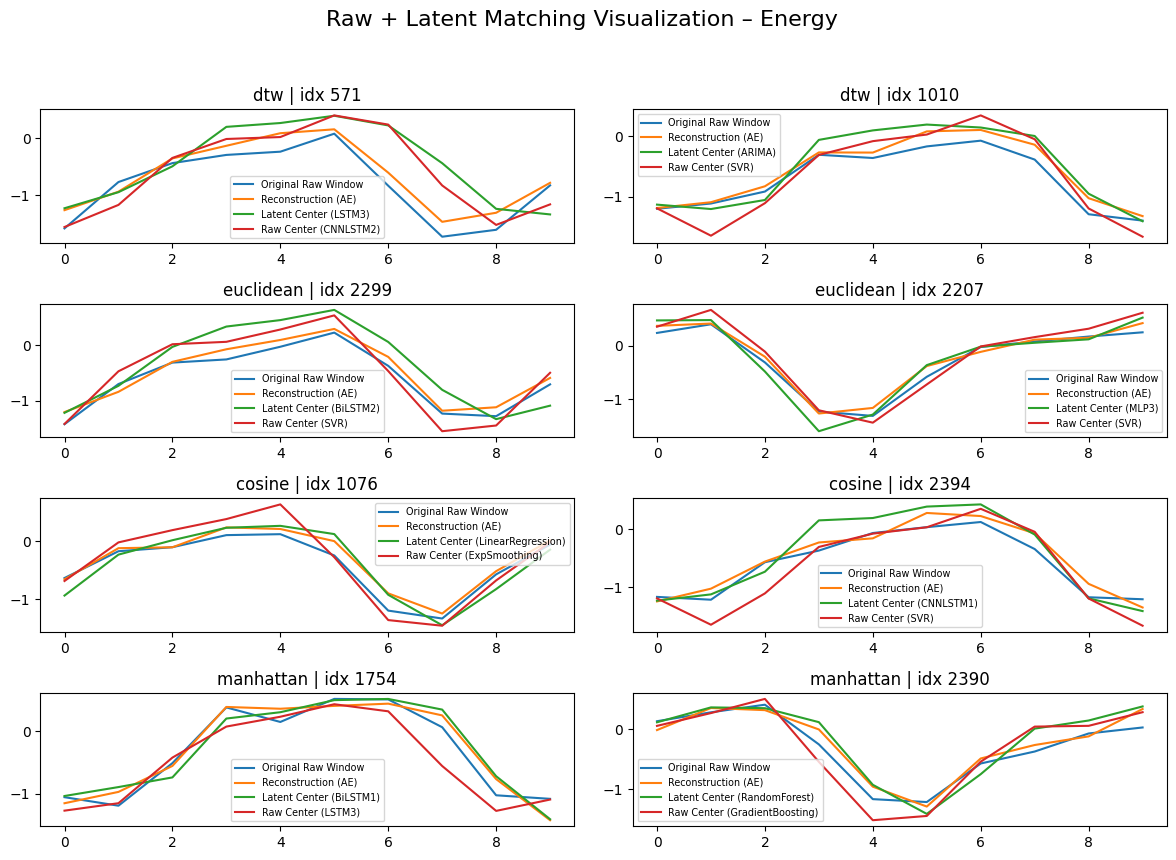

Processing dataset: RiverFlow


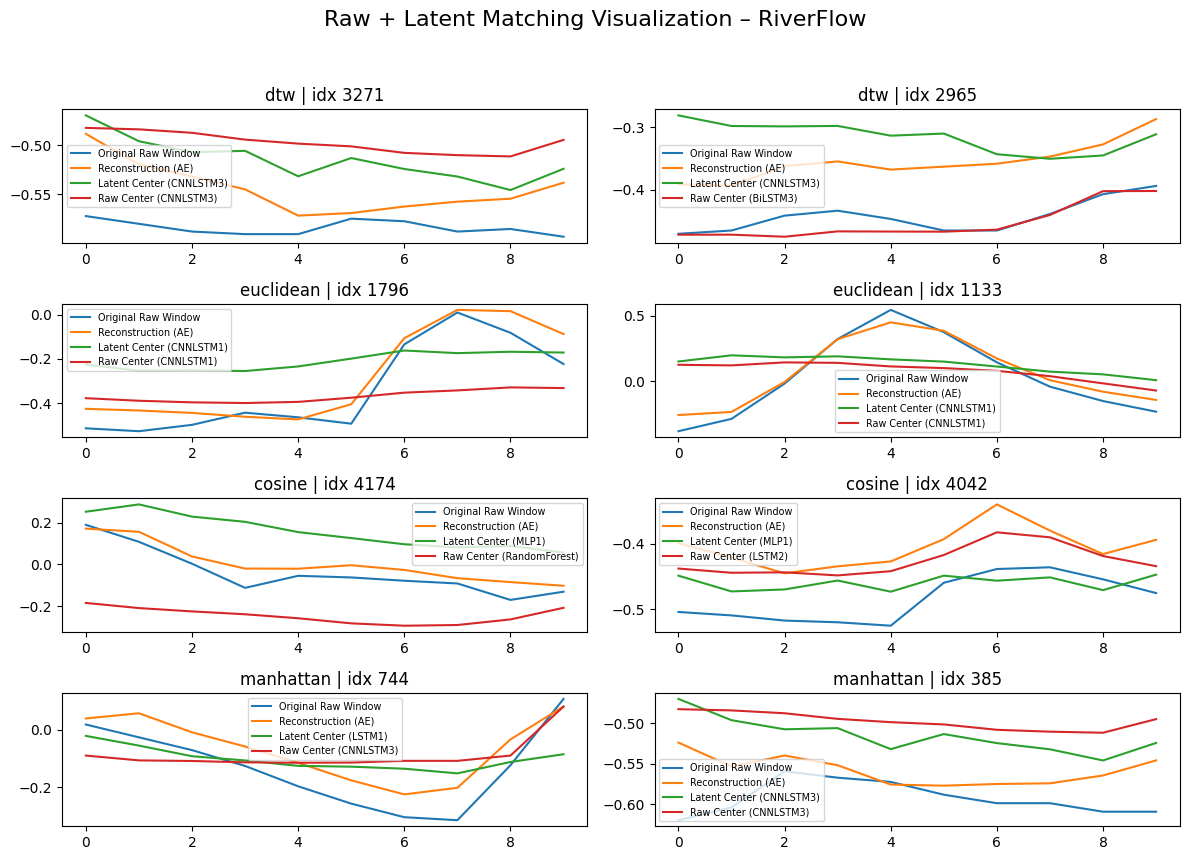

Processing dataset: Temperatures


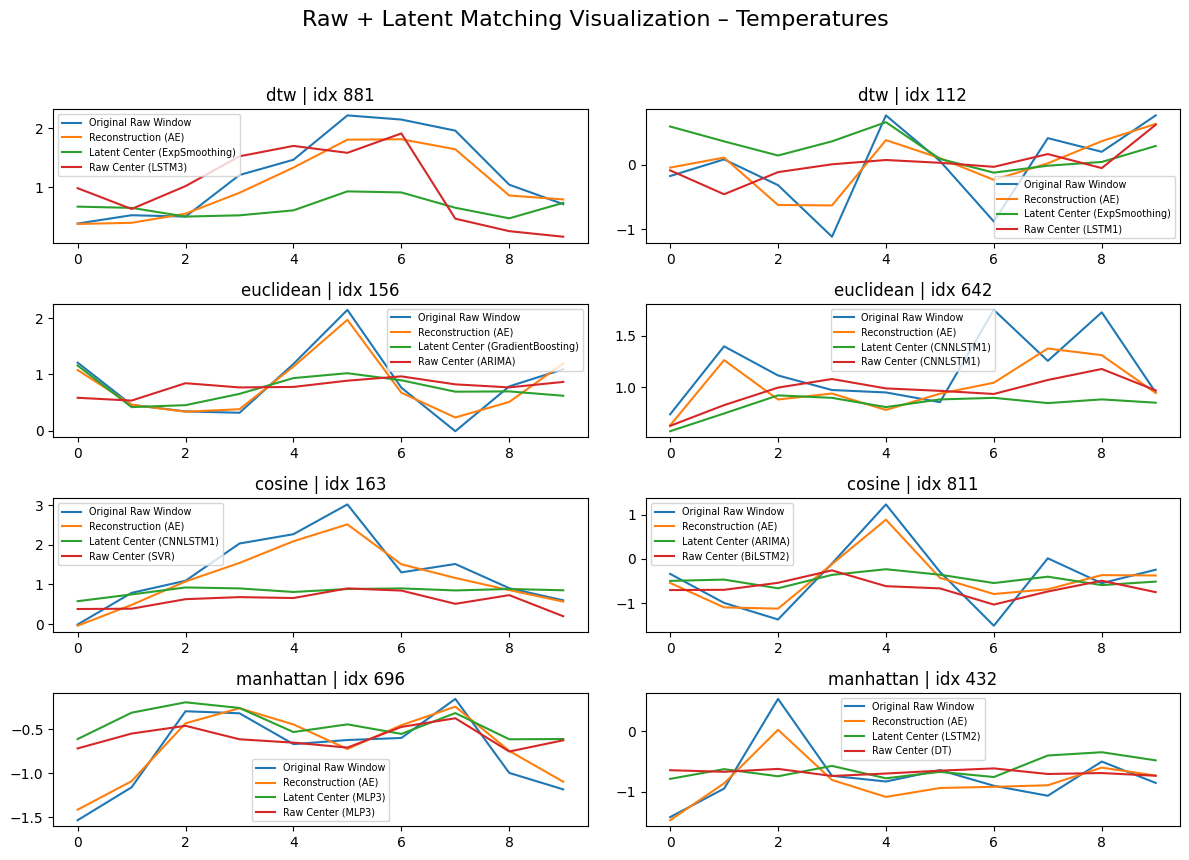

Processing dataset: Births


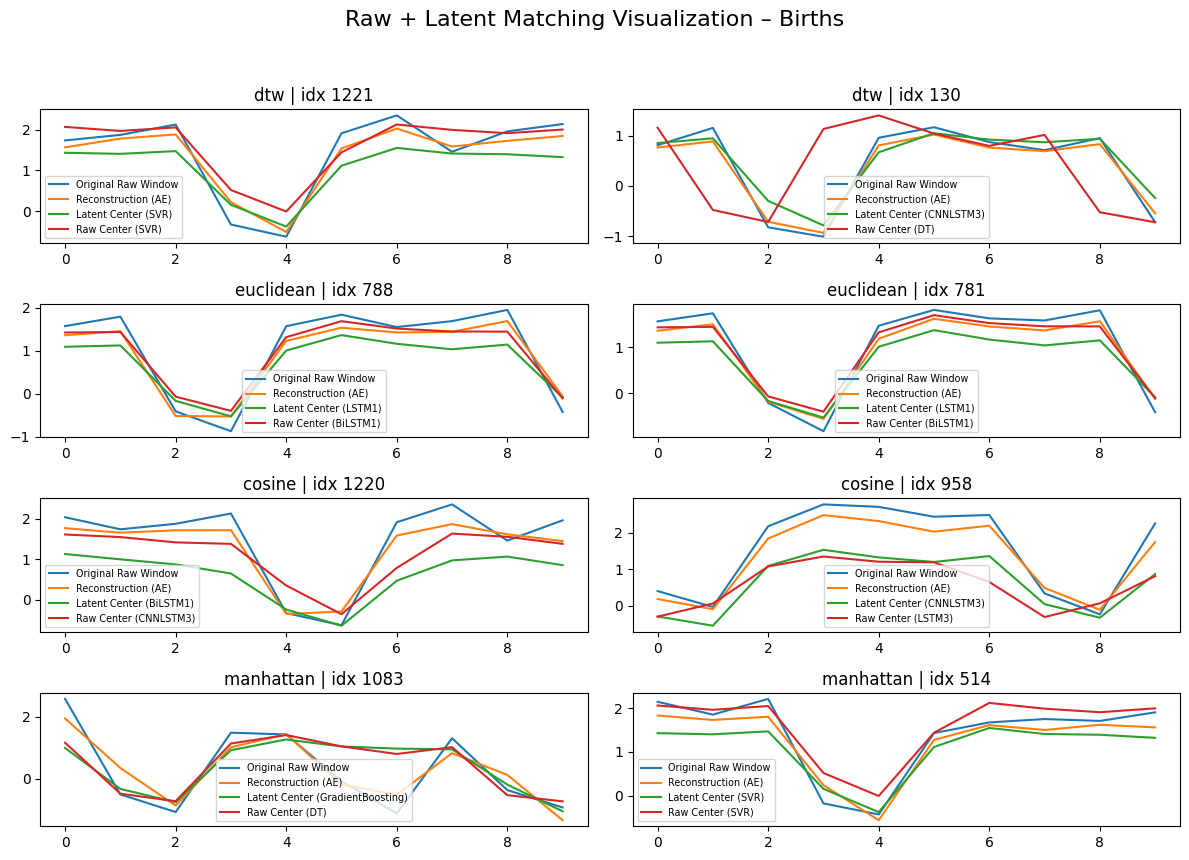

In [15]:
for ds_name, DS, length, window_size in ts_configs:
    print(f"Processing dataset: {ds_name}")

    # Load dataset and create test windows
    ts = DS(length=length)
    _, _, _, _, X_test, _ = windowing(ts.data, window_size)

    # Load AE and forecasters
    ae = loaded[ds_name]['ae']
    forecasters = loaded[ds_name]['forecasters']
    decoder = ae.decoder
    decoder_device = next(decoder.parameters()).device

    # Prepare 3x2 subplot grid: 3 metrics × 2 windows per metric
    fig, axes = plt.subplots(len(metrics_list), 2, figsize=(12, 9))
    axes = axes.reshape(-1, 2)  # Ensure consistent indexing

    for i, metric in enumerate(metrics_list):
        idxs = random.sample(range(len(X_test)), 2)

        for j, idx in enumerate(idxs):
            ax = axes[i, j]
            w = X_test[idx]  # NumPy array

            # Encode the window
            z = ae.encode(w)  # shape: (C, L)
            z_tensor = torch.tensor(z, dtype=torch.float32).unsqueeze(0).to(decoder_device)

            # Reconstruct the window
            with torch.no_grad():
                w_recon = decoder(z_tensor).cpu().numpy().flatten()

            # Find closest latent cluster center
            best_model_lat, best_dist_lat = None, float("inf")
            best_center_lat = None
            for name, model in forecasters.items():
                for center in model.centers["latent"]:
                    c_tensor = center if isinstance(center, torch.Tensor) else torch.tensor(center, dtype=torch.float32)
                    c_tensor = c_tensor.to(decoder_device)
                    d = compute_distance(z_tensor.squeeze(0), c_tensor, metric=metric)
                    if d < best_dist_lat:
                        best_dist_lat = d
                        best_model_lat = name
                        best_center_lat = c_tensor

            # Decode latent center
            with torch.no_grad():
                proto_latent = decoder(best_center_lat.unsqueeze(0)).cpu().numpy().flatten()

            # Find closest raw cluster center
            best_model_raw, best_dist_raw = None, float("inf")
            best_center_raw = None
            for name, model in forecasters.items():
                for center in model.centers["raw"]:
                    center_np = center if isinstance(center, np.ndarray) else center.cpu().numpy()
                    d = compute_distance(w, center_np, metric=metric)
                    if d < best_dist_raw:
                        best_dist_raw = d
                        best_model_raw = name
                        best_center_raw = center_np

            # Plot all
            ax.plot(w, label="Original Raw Window")
            ax.plot(w_recon, label="Reconstruction (AE)")
            ax.plot(proto_latent, label=f"Latent Center ({best_model_lat})")
            ax.plot(best_center_raw, label=f"Raw Center ({best_model_raw})")
            ax.set_title(f"{metric} | idx {idx}")
            ax.legend(fontsize="x-small")

    # Final layout
    fig.suptitle(f"Raw + Latent Matching Visualization – {ds_name}", fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()